# Machine Learning Portfolio Project: Betting Analysis and Model Formulation

We found on Kaggle a dataset (https://www.kaggle.com/datasets/bastekforever/complete-football-data-89000-matches-18-leagues) with detailed info about more than 96k football games from 18 european leagues, that took place between 2003 and 2022. Each record is equivalent to one football game. The info can be classified according to the following types: basic game info (date, teams, league...), game details (score, game events...), betting info (odds from unspecified bookmaker for betting victory home/draw/victory away, boolean value for betting possibilities).

Our purpose in this project is to examinate how the bookmakers' odds (which equate to converted probabilities by calculating the inverse number) relate to the actual results. We also want to introduce a second predictor that will monitor each team's ongoing trend over the past few games, compare it with the opposite team's, and check if added to the odds this predictor provides added accuracy for predicting a game's result. Based on this, can we elaborate a machine learning model able to make choices for us which will allow us to win in betting on the long term?

## Data Preparation

Given the large size of the dataset, we preferred to use Excel rather than Python to perform the manipulations we wanted to prepare the provided csv file for the analysis, due to an acceptable runtime with Excel and not with Python (at least with the ways to proceed that we had put in place). 

At first we removed the details of the individual games and the boolean fields advising of the fulfillment of possible betting events. 

We then added probabilities fields which are simply taking the inverse number of the odd for each event. We also pulled the characteristics of the most probable per the bookmakers outcome (what outcome, odds and probability). We inserted a column showing the outcome of the given game (1 = victory home team, X = draw, 2= victory away team).  And an other inserted column compares the most probable outcome (per the bookmaker) with the actual outcome and returns 1 if they are equal, 0 otherwise.

Then we attributed to each team its' coefficient for the game, equal to the number of points it scored given the result (0= defeat, 1 = draw, 3 = victory). We also attributed it the number of the given game for the team, within the boundaries of the dataframe. And based on that, we calculated the number of points each of the team of a given game scored during its' last 5 games (or 3 or 4 but in this case we normalized the value to a base of 5). In a new column, we substracted the "trend" indicator of the home team to the away team's. This added indicator is supposed to quantify the shape of each team over the last few games and how both relate. 

At this moment, we removed the records of games without odds or with too few past games to calculate properly the trend. This removed ~3k out of ~96k records from the dataset.  

This prepared csv was then processed via a Pandas Dataframe called 'data', the output of the second cell below shows how it looks like. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from datetime import datetime


In [2]:
data = pd.read_csv('Consolidated DS.csv')
data = data.sort_values(['Game ID']).reset_index(drop = True)
print(data.head())   


   Game ID       Date  Country     Competition        Home team    Away team  \
0        1  1/11/2003  England  premier-league           Bolton       Fulham   
1        2  1/11/2003  England  premier-league          Chelsea     Charlton   
2        3  1/11/2003  England  premier-league        Liverpool  Aston Villa   
3        4  1/11/2003  England  premier-league  Manchester City        Leeds   
4        5  1/11/2003  England  premier-league    Middlesbrough  Southampton   

   Home team game number  Away team game number  Trend home team  \
0                     22                     22                5   
1                     23                     22                5   
2                     23                     23                3   
3                     23                     23                8   
4                     23                     23                4   

   Trend away team  ...  Proba_total  Highest proba_outcome  \
0                4  ...         1.12           

## Dataset Exploration and Analysis

We are going to get familiar with the dataset and try to identify major trends within the results as well as regarding their relationship with the odds.

In [3]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93626 entries, 0 to 93625
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Game ID                          93626 non-null  int64  
 1   Date                             93626 non-null  object 
 2   Country                          93626 non-null  object 
 3   Competition                      93626 non-null  object 
 4   Home team                        93626 non-null  object 
 5   Away team                        93626 non-null  object 
 6   Home team game number            93626 non-null  int64  
 7   Away team game number            93626 non-null  int64  
 8   Trend home team                  93626 non-null  int64  
 9   Trend away team                  93626 non-null  int64  
 10  Trend delta (H-A)                93626 non-null  int64  
 11  Odd_1                            93626 non-null  float64
 12  Odd_X             

First interpretation to draw from above is that bookmakers favour in priority the home team, far more than the draw or the away team (everything else being equal), those two later events having quite close average odds/probabilities, with victory of the away team slightly ahead in the predictions. 

As the output of below cell is showing, the real data do display a larger share of home victories, but not as much as in the distribution of most probable outcomes according to the bookmaker. The shares of away victories are rather close in both distributions. But the share of draws in real life is much higher than per the bookmakers' probabilities.

In [4]:
av_proba = ['proba',round(data.Proba_1.mean(),2), round(data.Proba_X.mean(),2), round(data.Proba_2.mean(),2)]
print(data.Outcome.value_counts())
print(data['Highest proba_outcome'].value_counts())

Outcome
1    41308
2    26800
X    25518
Name: count, dtype: int64
Highest proba_outcome
1    69429
2    23969
X      228
Name: count, dtype: int64


Let's examine now the profiles of the games with each outcome, in terms of trend balance and of pre-game odd for the outcome that eventually happened.

In [5]:
sub_1 = data[data['Outcome'] == '1']
sub_X = data[data['Outcome'] == 'X']
sub_2 = data[data['Outcome'] == '2']

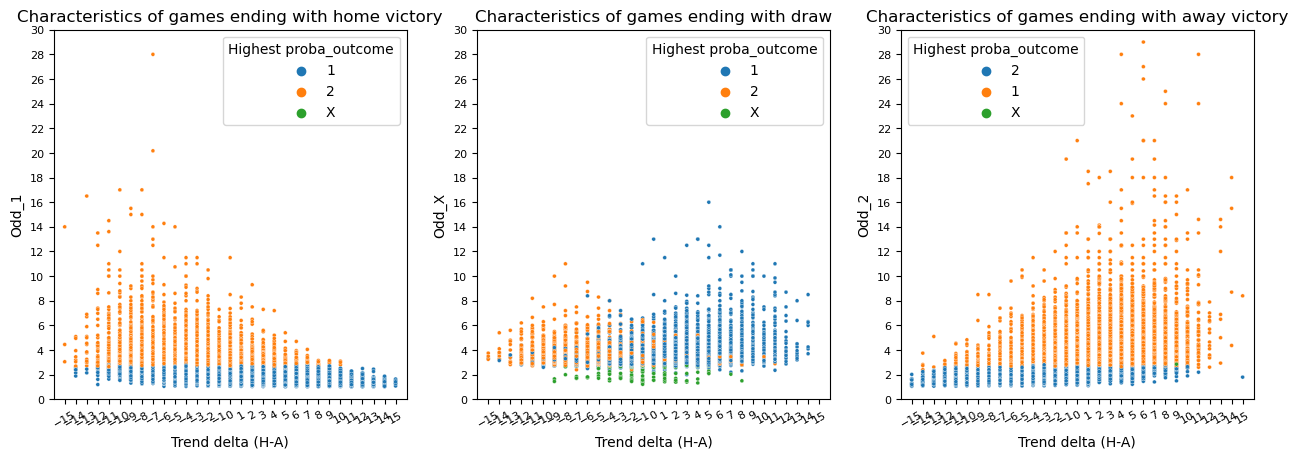

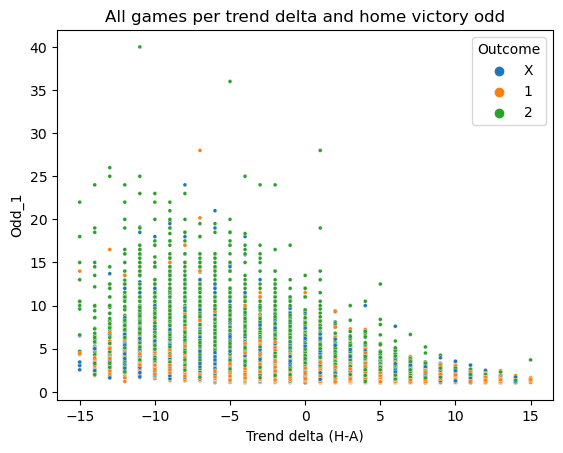

Home victories
count    41308.000000
mean         0.592210
std          4.483694
min        -15.000000
25%         -3.000000
50%          1.000000
75%          4.000000
max         15.000000
Name: Trend delta (H-A), dtype: float64
count    41308.000000
mean         2.110629
std          0.846706
min          1.030000
25%          1.620000
50%          1.970000
75%          2.400000
max         28.000000
Name: Odd_1, dtype: float64
Draws
count    25518.000000
mean        -0.441571
std          4.271447
min        -15.000000
25%         -3.000000
50%          0.000000
75%          2.000000
max         14.000000
Name: Trend delta (H-A), dtype: float64
count    25518.000000
mean         3.410112
std          0.647248
min          1.220000
25%          3.100000
50%          3.250000
75%          3.500000
max         16.000000
Name: Odd_X, dtype: float64
Away victories
count    26800.000000
mean        -1.359851
std          4.443792
min        -15.000000
25%         -4.000000
50%         -1

In [6]:
# Games ending with victory of home team
plt.subplot(1,3,1)
sns.scatterplot(x=sub_1['Trend delta (H-A)'],y=sub_1['Odd_1'], hue = sub_1['Highest proba_outcome'], s = 8)
plt.title('Characteristics of games ending with home victory')
plt.axis([-16,16,0,30])
plt.xticks(ticks = [i for i in range(-15,16,1)], rotation = 30, size = 8)
plt.yticks(ticks = [i for i in range(0,31,2)], size = 8)
# Games ending with draw
plt.subplot(1,3,2)
sns.scatterplot(x=sub_X['Trend delta (H-A)'],y=sub_X['Odd_X'],hue = sub_X['Highest proba_outcome'], s = 8)
plt.title('Characteristics of games ending with draw')
plt.axis([-16,16,0,30])
plt.xticks(ticks = [i for i in range(-15,16,1)], rotation = 30, size = 8)
plt.yticks(ticks = [i for i in range(0,31,2)], size = 8)
# Games ending with away victory
plt.subplot(1,3,3)
sns.scatterplot(x=sub_2['Trend delta (H-A)'],y=sub_2['Odd_2'],hue = sub_2['Highest proba_outcome'], s = 8)
plt.title('Characteristics of games ending with away victory')
plt.subplots_adjust(right = 2)
plt.axis([-16,16,0,30])
plt.xticks(ticks = [i for i in range(-15,16,1)], rotation = 30, size = 8)
plt.yticks(ticks = [i for i in range(0,31,2)], size = 8)
plt.show()
plt.clf()

sns.scatterplot(x=data['Trend delta (H-A)'],y=data['Odd_1'],hue = data['Outcome'], s = 8)
plt.title('All games per trend delta and home victory odd')
plt.show()

print('Home victories')
print(sub_1['Trend delta (H-A)'].describe())
print(sub_1['Odd_1'].describe())
print('Draws')
print(sub_X['Trend delta (H-A)'].describe())
print(sub_X['Odd_X'].describe())
print('Away victories')
print(sub_2['Trend delta (H-A)'].describe())
print(sub_2['Odd_X'].describe())

The odds of all three events are contained in intervals of small spread, save for the outliers. As could be expected the odds of the home victories are much lower than those for draws and away victories which in turn tend to be similar to each other. 

More or less every time that a draw was predicted it seems to have proven true, as no home or away victory game (or so little) was predicted to end as a draw. 

The visual can induce to confusion but as shown by the use of the .describe() function, home victories happen slightly more with a positive trend balance (home team 'better in shape' than away team) and away victories slightly more with a negative one (away team 'better in shape' than home team). Draws tend to happen when the trend balance slightly favours the away team, as shown by the mean.

An other point of special interest is how effective the bookmaker is at predicting a game's result. Bookmaker's prediction is considered to be the outcome given the highest probability or the lowest odd. Are there some results that are better predicted than others? Does and how is the accuracy increasing with the probability of the predicted outcome?

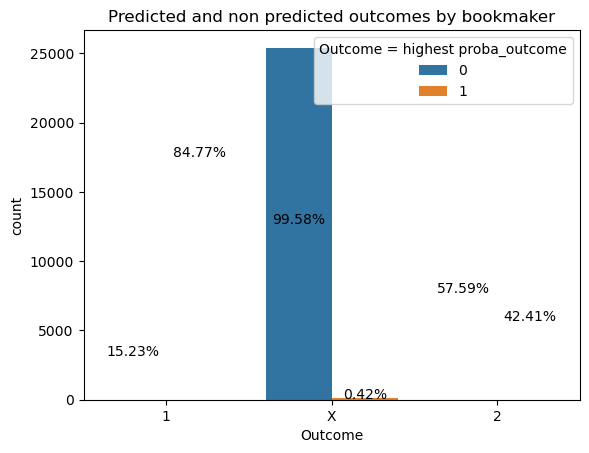

In [7]:
#Here we define a function allowing us to place value labels on our visuals
def add_value_label_perc(x_list, y_list_val, y_list_pct):
    for i in range(len(x_list)):
        plt.text(x_list[i], y_list_val[i]/2, str(round(100*y_list_pct[i],2))+'%', ha = 'center')

x_labels = []
for x in range(3):
    x_labels.append(x-0.2)
    x_labels.append(x+0.2)


val_labels = []

for outcome in ['1','X','2']:
    val_labels.append(len(data[(data['Outcome'] == outcome) & (data['Outcome = highest proba_outcome'] == 0)]))
    val_labels.append(len(data[(data['Outcome'] == outcome) & (data['Outcome = highest proba_outcome'] == 1)]))

val_labels_pct = []

for i in range(6):
    if i%2 == 0:
        val_labels_pct.append(val_labels[i]/(val_labels[i]+val_labels[i+1]))
    else:
        val_labels_pct.append(val_labels[i]/(val_labels[i-1]+val_labels[i]))



        
sns.countplot(x='Outcome', hue='Outcome = highest proba_outcome', order = [1,'X',2], data=data)
plt.title('Predicted and non predicted outcomes by bookmaker')
add_value_label_perc(x_labels,val_labels, val_labels_pct)
plt.show()

The rate of correct prediction displays important contrasts at the level of individual outcomes. Above shows that some ~85% of the home team victories, the most probable outcome, were correctly predicted. However the rate of draws ('X') that were correctly predicted is close to 0%. As for the victories of the away team, a minority of some 40% of such outcomes were correctly predicted. 

Let us see if and how the precision evolves while the probability of the most probable outcome increases. We saw that it ranges from 0.34 to 0.97, which is a large range.

With highest proba between 0.34 and 0.5, the rate of correct predictions by the bookmaker is:
0.4
With highest proba between 0.5 and 0.6, the rate of correct predictions by the bookmaker is:
0.51
With highest proba between 0.6 and 0.7, the rate of correct predictions by the bookmaker is:
0.61
With highest proba between 0.7 and 0.8, the rate of correct predictions by the bookmaker is:
0.73
With highest proba between 0.8 and 0.9, the rate of correct predictions by the bookmaker is:
0.84
With highest proba between 0.9 and 1, the rate of correct predictions by the bookmaker is:
0.92


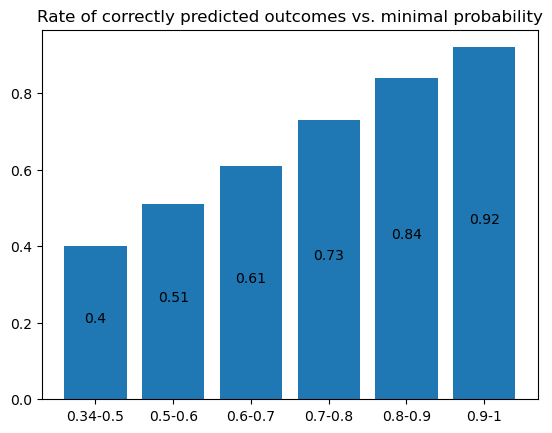

In [8]:
intervals = [[0.34,0.5], [0.5,0.6], [0.6,0.7], [0.7,0.8], [0.8, 0.9], [0.9,1]]

precision = []

for int in intervals:
    restricted_data = data[(data['Highest proba_val'] >= int[0]) & (data['Highest proba_val'] < int[1])]
    print(f'With highest proba between {int[0]} and {int[1]}, the rate of correct predictions by the bookmaker is:')
    print(round(restricted_data['Outcome = highest proba_outcome'].mean(),2))
    precision.append(round(restricted_data['Outcome = highest proba_outcome'].mean(),2))

    
plt.bar(['0.34-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1'],precision)
plt.title('Rate of correctly predicted outcomes vs. minimal probability')
for i in [0,1,2,3,4,5]:
    plt.text(i, precision[i]/2, precision[i], ha = 'center')
plt.show()

The above loop and plot display a very contrasted performance depending on the probability given by the bookmaker to the most probable outcome. The precision is mechanically increasing with the probability, probability being a mirror of the evaluation of the balance of forces of the two teams that are playing a game, just before it is played. The statistics show that if we follow every time the bookmaker's predictions with 70 to 80% of chances, we will be right 73% of the times, and for predictions between 90 to 100%, we will be right 92% of the time.

We saw that the bookmaker almost never predicts draws, eventhough draws make up almost 30% of the results. We saw as well that home team victories were most of the times predicted and away team victories not predicted in the majority of the cases. But when the bookmaker predicted each of these outcomes, how did it perform?

[0.4, 0.5, 0.61, 0.73, 0.84, 0.93]
[0.41, 0.52, 0.62, 0.74, 0.8, 0.9]


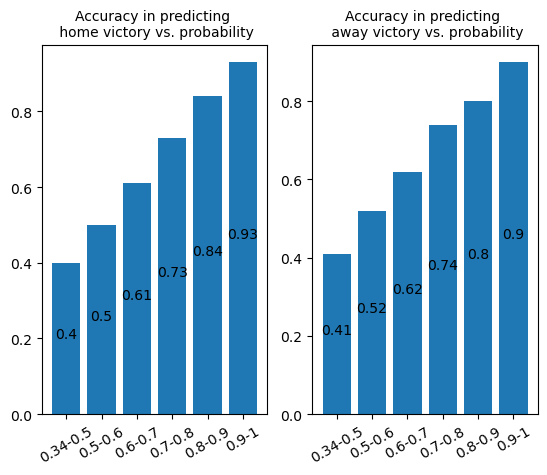

In [9]:
sub_home_V = data[data['Highest proba_outcome'] == '1'] 
sub_away_V = data[data['Highest proba_outcome'] == '2'] 

intervals = [[0.34,0.5], [0.5,0.6], [0.6,0.7], [0.7,0.8], [0.8, 0.9], [0.9,1]]

precision_home = []
precision_away = []




for int in intervals:
    restricted_data_home = sub_home_V[(sub_home_V['Highest proba_val'] >= int[0]) & (sub_home_V['Highest proba_val'] < int[1])]
    restricted_data_away = sub_away_V[(sub_away_V['Highest proba_val'] >= int[0]) & (sub_away_V['Highest proba_val'] < int[1])]
    precision_home.append(round(restricted_data_home['Outcome = highest proba_outcome'].mean(),2))
    precision_away.append(round(restricted_data_away['Outcome = highest proba_outcome'].mean(),2))



print(precision_home)
print(precision_away)
    

plt.subplot(1,2,1)
plt.bar(['0.34-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1'], precision_home)
plt.title('Accuracy in predicting \n home victory vs. probability',size = 10)
plt.xticks(rotation=30)
for i in [0,1,2,3,4,5]:
    plt.text(i, precision_home[i]/2, precision_home[i], ha = 'center')
plt.subplot(1,2,2)
plt.bar(['0.34-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1'], precision_away)
plt.title('Accuracy in predicting \n away victory vs. probability',size = 10)
plt.xticks(rotation=30)
for i in [0,1,2,3,4,5]:
    plt.text(i, precision_away[i]/2, precision_away[i], ha = 'center')
plt.show()

We don't observe a gap in the performance of the bookmaker's predictions depending on whether the prediction is home victory or away victory. Only for the highest probabilities can we see that the away victory happens a few percentage points less than home victory, but the difference is small. 

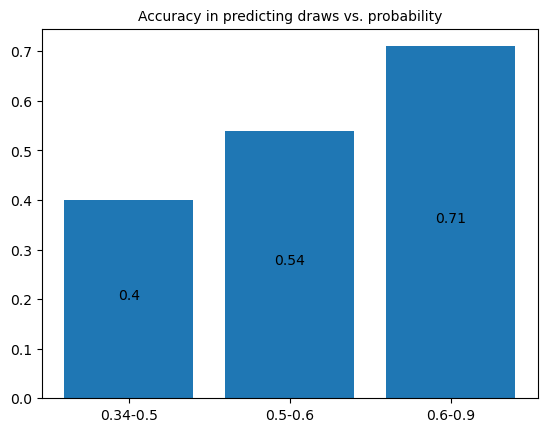

In [10]:
sub_X = data[data['Highest proba_outcome'] == 'X'] 



#given the limited number of records with draw predictions and the uneven spread across probabilities, we will compare accuracy for only three intervals 
#the three intervals hold respectively 149, 41 and 38 records

intervals = [[0.34,0.5], [0.5,0.6], [0.6,0.9]]



precision_draw = []




for int in intervals:
    restricted_X = sub_X[(sub_X['Highest proba_val'] >= int[0]) & (sub_X['Highest proba_val'] < int[1])]
    precision_draw.append(round(restricted_X['Outcome = highest proba_outcome'].mean(),2))




    

plt.bar(['0.34-0.5','0.5-0.6','0.6-0.9'], precision_draw)
plt.title('Accuracy in predicting draws vs. probability',size = 10)
for i in [0,1,2]:
    plt.text(i, precision_draw[i]/2, precision_draw[i], ha = 'center')
plt.show()

Based on above, the bookmaker isn't significantly performing better at predicting any of the three possible outcomes, for a given level of probability, the accuracy is equivalent for the home victory, away victory and draw outcomes. 

We now want to examine if there are strategies of automatic alignment on the bookmaker's prediction that pay off and if yes, based on what probabilities? Which of these strategies provides the better return on investment?

For each unique probability of most possible event, we are going to calculate our cash balance and the % of win/loss if we bet 1 currency unit (in our case euro) on each bookmaker's prediction with a probability that is higher or equal to this probability.

[93626, 93618, 93567, 93074, 91970, 89100, 86633, 82373, 78597, 74416, 68879, 63890, 59631, 58400, 54466, 50644, 47523, 43469, 40190, 38379, 34991, 32549, 30983, 27591, 25439, 23840, 22124, 20391, 18404, 17510, 15548, 14625, 13001, 12175, 11068, 9830, 8903, 8097, 7159, 6617, 6252, 5494, 4932, 4425, 3981, 3509, 3025, 2704, 2275, 1996, 1500, 1356, 1018, 918, 764, 502, 368, 294, 219, 161, 63, 29, 12, 5]
[0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47
 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61
 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75
 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89
 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97]
[-0.0546, -0.0546, -0.0546, -0.0545, -0.0539, -0.0533, -0.0515, -0.0498, -0.0483, -0.0476, -0.0479, -0.0446, -0.0436, -0.0445, -0.0447, -0.0434, -0.0433, -0.0413, -0.0399, -0.0386, -0.0345, -0.0317, -0.0309, -0.0291, -0.0274, -0.0274, -0.0257, -0.0248, -0.0226, -0.0224,

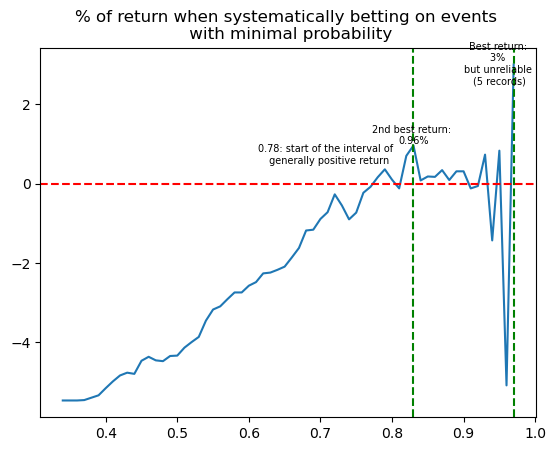

In [11]:
from decimal import Decimal

most_probable_probas = data['Highest proba_val'].unique()
most_probable_probas.sort()

#first below list is for the nb of correctly predicted outcomes, second is for the total nb of outcomes
#third contains gains which is the sum of the odds of correctly predicted outcomes 

nb_favourable_outcomes = []
nb_outcomes = []
gain = []


for proba in most_probable_probas:
    nb_favourable_outcomes.append(len(data[(data['Highest proba_val'] >= proba) & (data['Outcome = highest proba_outcome'] ==1)]))
    nb_outcomes.append(len(data[(data['Highest proba_val'] >= proba)]))
    gain.append(data[(data['Highest proba_val'] >= proba) & (data['Outcome = highest proba_outcome'] ==1)]['Highest proba_odd'].sum())

print(nb_outcomes)


#balance is calculating by substracting the nb of outcomes from the gains, for each strategy of minimal probability
balance = []

for i in range(len(nb_outcomes)):
    balance.append(round(gain[i]-nb_outcomes[i],2))
    
print(most_probable_probas)


balance_percent = []

for i in range(len(nb_outcomes)):
    balance_percent.append(round(balance[i]/nb_outcomes[i],4))

print(balance_percent)

plt.plot(most_probable_probas, [bal*100 for bal in balance_percent])
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0.97, color='g', linestyle='--')
plt.axvline(x=0.83, color='g', linestyle='--')
plt.text(0.83, 0.99, '2nd best return: \n0.96%', ha = 'center', size = 7)
plt.text(0.95, 2.5, 'Best return: \n3% \nbut unreliable \n(5 records)', ha = 'center', size = 7)
plt.text(0.71, 0.5, '0.78: start of the interval of \n generally positive return', ha = 'center', size = 7)
plt.title('% of return when systematically betting on events \n with minimal probability')
plt.show()

We can see from above that in general betting at or above around 80% of probability (which equates to odds of 1.25) is likely to generate positive returns but very modest, whereas decreasing from this threshold generates increasing loss. For the highest probabilities, the results both positive and negatives are to take with caution due to the low number of records (only 5 for the games with 0.97 proba of most probable event).

We also briefly discussed at the beginning of this notebook another indicator, which is the trends over the last games of the two teams and their balance. Has this balance some predictive value, alone and combined with the odds?

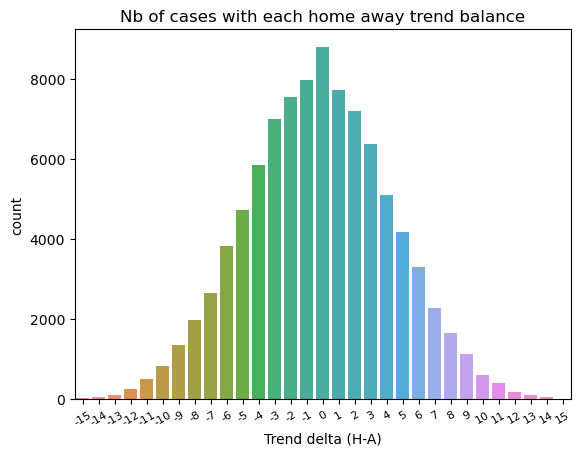

Number of games where delta is >0 : 40231
Number of games where delta is <0: 44602


In [12]:
sns.countplot(x='Trend delta (H-A)', data=data)
plt.title('Nb of cases with each home away trend balance')
plt.xticks(rotation=30,size=8)
plt.show()


above_z = len(data[data['Trend delta (H-A)']>0])
below_z = len(data[data['Trend delta (H-A)']<0])


print(f'Number of games where delta is >0 : {above_z}')
print(f'Number of games where delta is <0: {below_z}')

We see that the delta of the trends follows an almost perfectly normal distribution, although tightly skewed on the right because there are some 4000 more records with a negative balance than with a positive one. 

For each delta possibility, how are the outcomes distributed?

0.256
0.20133333333333336
[-15.1, -14.1, -13.1, -12.1, -11.1, -10.1, -9.1, -8.1, -7.1, -6.1, -5.1, -4.1, -3.1, -2.1, -1.1, -0.1, 0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, 11.9, 12.9, 13.9, 14.9]
[-14.9, -13.9, -12.9, -11.9, -10.9, -9.9, -8.9, -7.9, -6.9, -5.9, -4.9, -3.9, -2.9, -1.9, -0.9, 0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 14.1, 15.1]
[-14.7, -13.7, -12.7, -11.7, -10.7, -9.7, -8.7, -7.7, -6.7, -5.7, -4.7, -3.7, -2.7, -1.7, -0.7, 0.3, 1.3, 2.3, 3.3, 4.3, 5.3, 6.3, 7.3, 8.3, 9.3, 10.3, 11.3, 12.3, 13.3, 14.3, 15.3]


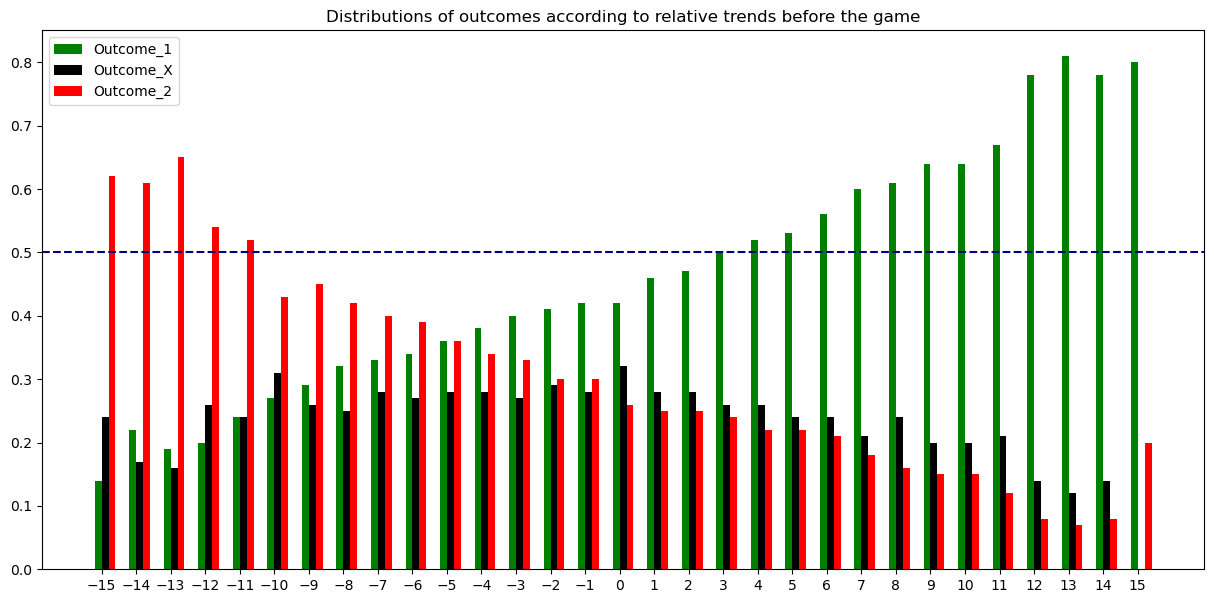

In [13]:
one_perc_per_delta = []
x_perc_per_delta = []
two_perc_per_delta = []


for i in range(-15,16):
    one = len(data[(data['Trend delta (H-A)'] == i) & (data['Outcome'] == '1')])
    x = len(data[(data['Trend delta (H-A)'] == i) & (data['Outcome'] == 'X')])
    two = len(data[(data['Trend delta (H-A)'] == i) & (data['Outcome'] == '2')])
    one_perc_per_delta.append(round(one/(one+x+two),2))
    x_perc_per_delta.append(round(x/(one+x+two),2))
    two_perc_per_delta.append(round(two/(one+x+two),2))

draw_adv_away = 0
draw_adv_home = 0

for prop in x_perc_per_delta[:15]:
    draw_adv_away += prop
draw_adv_away = draw_adv_away/15
print(draw_adv_away)

for prop in x_perc_per_delta[16:]:
    draw_adv_home += prop
draw_adv_home = draw_adv_home/15
print(draw_adv_home)

n1 = 1
nx = 2
n2 = 3
t = 2
d= range(-15,16)
w = 0.5


x_one = [el -0.1 for el in d]
x_draw = [el +0.1 for el in d]
x_two = [el +0.3 for el in d]
   
print(x_one)
print(x_draw)
print(x_two)
plt.figure(figsize = (15,7))
ax = plt.subplot()
plt.bar(x_one, one_perc_per_delta, width = 0.2, color = 'green')
plt.bar(x_draw, x_perc_per_delta,width = 0.2, color = 'black')
plt.bar(x_two, two_perc_per_delta, width = 0.2, color = 'red')
ax.set_xticks([i for i in range(-15,16)])
plt.legend(['Outcome_1', 'Outcome_X', 'Outcome_2'])
plt.axhline(y=0.5, color='navy', linestyle='--')
plt.title('Distributions of outcomes according to relative trends before the game')
plt.show()

The above visual supports the idea of a relationship between the trend of the two teams before the start of the game and the final result. When the away team has an advantage of more than 10 points, it wins in more than 50% of the cases. Between 10 and 5 points advantage for the away team, victory of the away team remains the result with the relative majority.

Victory of the home team gets the relative majority as early as when the trend still favours the away team by 4 points and from this moment keeps increasing in proportion. It exceeds the absolute majority when the home team has an advantage of 4 points. In the scenarios with the highest advantage in the trend for the home team (12 to 15 points), victory of the home team happens in around 80% of the cases.

Whichever trend difference is taken, the draw scenario is never the most prevalent. The proportion of draws peaks in scenarios where away team has a 10 points advantage and when no team is favoured by the trend, at respectively 31% and 32%.

What happens if we use for betting a combination of the odds and of the trends? 
Let's test the return of a strategy of betting for the home or the away team if 1) the odds favor the home or away team and 2) the trend balance between the two teams is such that statistically the home or the away team has more than 50% of chances to win (it corresponds to a delta between 4 and 15 for the home team and between -15 and -11 for the away team). We will refer to this pre-game scenario as 'S'.

In [14]:
betting_home_S = data[(data['Trend delta (H-A)']> 3) & (data['Highest proba_outcome'] == '1')]
betting_away_S = data[(data['Trend delta (H-A)'] < -10) & (data['Highest proba_outcome'] == '2')]

print(f'The S scenario applies for {len(betting_home_S)} records with favoured home team \nand for {len(betting_away_S)} records with away team favoured, \nin total {len(betting_away_S)+len(betting_home_S)} records')


The S scenario applies for 17885 records with favoured home team 
and for 784 records with away team favoured, 
in total 18669 records


In [15]:
gain_home_S = betting_home_S[(betting_home_S['Outcome = highest proba_outcome'] == 1)]['Highest proba_odd'].sum()
gain_away_S = betting_away_S[(betting_away_S['Outcome = highest proba_outcome'] == 1)]['Highest proba_odd'].sum()

gain_S = gain_home_S + gain_away_S
return_S = gain_S - (len(betting_away_S)+len(betting_home_S))

print('Cash movements if betting per scenario S')
print(f'Gains for home victory bets: {round(gain_home_S,2)}')
print(f'Gains for away victory bets: {gain_away_S}')
print(f'Total gains : {gain_S}')
print(f'Cash balance: {round(return_S,2)}')
print(f'Balance per game = {round(return_S/(len(betting_away_S)+len(betting_home_S)),4)}')

print('Cash balance if betting only according to highest proba:')
print(round((data[(data['Outcome = highest proba_outcome'] == 1)]['Highest proba_odd'].sum()-len(data))/len(data),4))


Cash movements if betting per scenario S
Gains for home victory bets: 17070.44
Gains for away victory bets: 732.69
Total gains : 17803.13
Cash balance: -865.87
Balance per game = -0.0464
Cash balance if betting only according to highest proba:
-0.0546


This strategy if applied looks doomed to make us lose money, what is not our goal. We notice that it makes us lose slightly less money per game than if we just bet on the highest probability scenario, therefore enhancing a little the precision (but very marginally). 
What happens if we apply it only to games where the victory of home or away team have a minimal level of probability?

In [16]:
thresholds = [0.5,0.6,0.7,0.8,0.9]

for t in thresholds:
    subset_home = betting_home_S[(betting_home_S['Highest proba_val']>= t)]
    subset_away = betting_away_S[(betting_away_S['Highest proba_val']>= t)]
    nb_home = len(subset_home)
    nb_away = len(subset_away)
    gain_home = subset_home[(subset_home['Outcome = highest proba_outcome'] == 1)]['Highest proba_odd'].sum()
    gain_away = subset_away[(subset_away['Outcome = highest proba_outcome'] == 1)]['Highest proba_odd'].sum()
    print(f'Returns if betting as per adapted S scenario with minimal probability of {t}')
    print(f'(Number of games: {nb_away+nb_home})')
    print(f'Gains: {round(gain_away+gain_home,4)}')
    print(f'Cash balance: {round((gain_away+gain_home)-(nb_away+nb_home),4)}')
    print(f'Cash balance per game: {round(((gain_away+gain_home)-(nb_away+nb_home))/(nb_away+nb_home),4)}')

Returns if betting as per adapted S scenario with minimal probability of 0.5
(Number of games: 14321)
Gains: 13777.51
Cash balance: -543.49
Cash balance per game: -0.038
Returns if betting as per adapted S scenario with minimal probability of 0.6
(Number of games: 9123)
Gains: 8942.68
Cash balance: -180.32
Cash balance per game: -0.0198
Returns if betting as per adapted S scenario with minimal probability of 0.7
(Number of games: 4812)
Gains: 4794.26
Cash balance: -17.74
Cash balance per game: -0.0037
Returns if betting as per adapted S scenario with minimal probability of 0.8
(Number of games: 2082)
Gains: 2101.01
Cash balance: 19.01
Cash balance per game: 0.0091
Returns if betting as per adapted S scenario with minimal probability of 0.9
(Number of games: 296)
Gains: 297.22
Cash balance: 1.22
Cash balance per game: 0.0041


We can observe a slightly positive result when betting on outcome with probability >= 0.8, plus the trend conditions that we know, but this is clearly not much.
Instead of these rule of thumbs trials, can we work out a machine learning model that will be able to provide us more rewarding predictions?

# K-Nearest Neighbors Machine Learning Model

We will use the K Nearest Neighbors classification algorithm from the scikit library. This algorithm is going to proceed to classification by matching an isolated datapoint with a determined number (to be optimized) of this datapoint's closest counterparts. We expect that the model might not be profitable in general but that segmenting its use to specific datapoints (and not betting for the others) might be a fruitful approach.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(data.head())

   Game ID       Date  Country     Competition        Home team    Away team  \
0        1  1/11/2003  England  premier-league           Bolton       Fulham   
1        2  1/11/2003  England  premier-league          Chelsea     Charlton   
2        3  1/11/2003  England  premier-league        Liverpool  Aston Villa   
3        4  1/11/2003  England  premier-league  Manchester City        Leeds   
4        5  1/11/2003  England  premier-league    Middlesbrough  Southampton   

   Home team game number  Away team game number  Trend home team  \
0                     22                     22                5   
1                     23                     22                5   
2                     23                     23                3   
3                     23                     23                8   
4                     23                     23                4   

   Trend away team  ...  Proba_total  Highest proba_outcome  \
0                4  ...         1.12           

Our first task is to find the number of closest neighbors a datapoint is matched with that returns the best accuracy in general.
This number obtained, we are going to formalize our model, use it and intensively analyze it going forward.

   Game ID       Date  Country     Competition        Home team    Away team  \
0        1  1/11/2003  England  premier-league           Bolton       Fulham   
1        2  1/11/2003  England  premier-league          Chelsea     Charlton   
2        3  1/11/2003  England  premier-league        Liverpool  Aston Villa   
3        4  1/11/2003  England  premier-league  Manchester City        Leeds   
4        5  1/11/2003  England  premier-league    Middlesbrough  Southampton   

   Home team game number  Away team game number  Trend home team  \
0                     22                     22                5   
1                     23                     22                5   
2                     23                     23                3   
3                     23                     23                8   
4                     23                     23                4   

   Trend away team  ...  Proba_total  Highest proba_outcome  \
0                4  ...         1.12           

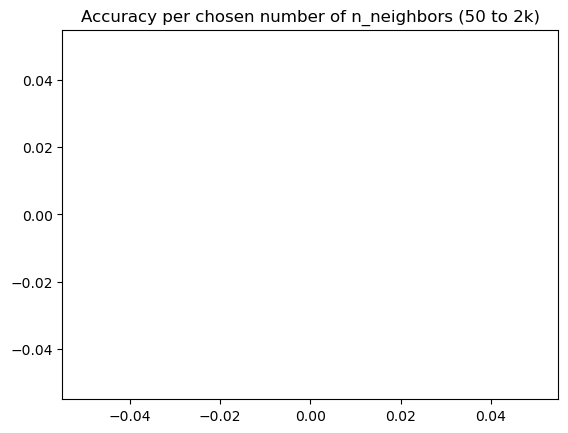

In [18]:
# we split the dataset and normalize the predictors

X = data[['Odd_1', 'Odd_X', 'Odd_2','Trend delta (H-A)']]
y = data['Outcome']
print(data.head())
std = StandardScaler()
print(X.head())
print(X['Odd_1'].mean())
print(X['Odd_1'].std())
print(X['Odd_X'].mean())
print(X['Odd_X'].std())
print(X['Odd_2'].mean())
print(X['Odd_2'].std())
print(X['Trend delta (H-A)'].mean())
print(X['Trend delta (H-A)'].std())



X = std.fit_transform(X)
print(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, test_size = 0.2,random_state = 59)





accuracies  = {}

# for i in range(50,2001,50):
#      KNN = KNeighborsClassifier(n_neighbors = i)
#      KNN.fit(X_train,y_train)
#      accuracies[i] = accuracy_score(y_test, KNN.predict(X_test))
    
print(accuracies)

plt.plot(accuracies.keys(), accuracies.values())
plt.title('Accuracy per chosen number of n_neighbors (50 to 2k)')
plt.show()

We observe that the optimal value is located around 700, let's look with a tighter focus to find the exact value with the highest performance (although the difference won't be impressive)

{}


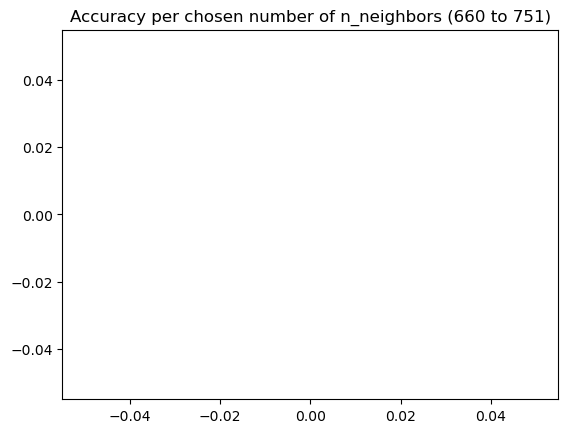

In [19]:
accuracies_zoomed  = {}

# for i in range(660,751,1):
#     KNN = KNeighborsClassifier(n_neighbors = i)
#     KNN.fit(X_train,y_train)
#     accuracies_zoomed[i] = accuracy_score(y_test, KNN.predict(X_test))
    
print(accuracies_zoomed)

plt.plot(accuracies_zoomed.keys(), accuracies_zoomed.values())
plt.title('Accuracy per chosen number of n_neighbors (660 to 751)')
plt.show()

711 is the number of n_neighbors that maximises the accuracy (by a thin margin compared to other values of the parameter, but still), so we will use it.

In [20]:
X = data[['Odd_1', 'Odd_X', 'Odd_2','Trend delta (H-A)']]
y = data['Outcome']
std = StandardScaler()
X = std.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, test_size = 0.2,random_state = 59)

KNN_model = KNeighborsClassifier(n_neighbors = 711)
KNN_model.fit(X_train, y_train)

KNN_preds = KNN_model.predict(X_test)
print(X_test)
KNN_preds_proba = KNN_model.predict_proba(X_test)

print('Confusion Matrix')
KNN_conf = confusion_matrix(y_test, KNN_preds)
print(KNN_conf)
print('Normalized Confusion Matrix')
KNN_conf_norm = confusion_matrix(y_test, KNN_preds, normalize = 'pred')
print(KNN_conf_norm)                               



[[ 0.16988995  0.02241889 -0.48416325 -1.05802153]
 [ 0.06037627 -0.33317694 -0.5091956   0.27795358]
 [-0.40688205 -0.18077873 -0.20165532 -1.50334656]
 ...
 [ 1.26502665  0.02241889 -0.75236699 -0.39003397]
 [-0.69891851  0.98760757  0.90692013  0.94594113]
 [ 1.37454032  0.02241889 -0.77382329 -1.50334656]]
Confusion Matrix
[[6904 1165  147]
 [3073 2158  115]
 [3782 1234  148]]
Normalized Confusion Matrix
[[0.50178065 0.25565065 0.35853659]
 [0.22334472 0.47355716 0.2804878 ]
 [0.27487463 0.27079219 0.36097561]]


In [21]:
balance_one = -13759
balance_x = -410
balance_two = -4557

# we now want to fetch the odds to calculate the gain, so we put back X in the state it was before the normalization

X = data[['Odd_1', 'Odd_X', 'Odd_2','Trend delta (H-A)']]
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, test_size = 0.2,random_state = 59)



X_test = X_test.reset_index(drop = True)
Test_1 = X_test['Odd_1']
Test_2 = X_test['Odd_2']
Test_X = X_test['Odd_X']
y_test = y_test.reset_index(drop = True)
print(Test_1)
print(KNN_preds)
print(y_test)


for i in range(len(X_test)):
    if KNN_preds[i] == '1':
        if y_test[i] == '1':
            balance_one += Test_1[i]
    elif KNN_preds[i] == 'X':
        if y_test[i] == 'X':
            balance_x += Test_X[i]
    elif KNN_preds[i] == '2':
        if y_test[i] == '2':
            balance_two += Test_2[i]
            
print(f'Balance when using the model\'s predictions for home victory only')
print(f'Abs: {balance_one}')
print(f'%: {(balance_one/(KNN_conf[0][0]+KNN_conf[1][0]+KNN_conf[2][0]))*100}')
print(f'Balance when using the model\'s predictions for draws only')
print(f'Abs: {balance_x}')
print(f'%: {(balance_x/(KNN_conf[0][2]+KNN_conf[1][2]+KNN_conf[2][2]))*100}')
print(f'Balance when using the model\'s predictions for away victory only')
print(f'Abs: {balance_two}')
print(f'%: {(balance_two/(KNN_conf[0][1]+KNN_conf[1][1]+KNN_conf[2][1]))*100}')
print(f'Balance when using the model\'s predictions for all scenarios')
print(f'Abs: {balance_one+balance_x+balance_two}')
print(f'%: {((balance_one+balance_x+balance_two)/(18726))*100}')

0        2.70
1        2.55
2        1.91
3        1.45
4        2.70
         ... 
18721    2.70
18722    1.48
18723    4.20
18724    1.51
18725    4.35
Name: Odd_1, Length: 18726, dtype: float64
['2' '1' '1' ... '2' '1' '2']
0        2
1        2
2        1
3        1
4        1
        ..
18721    1
18722    X
18723    2
18724    X
18725    2
Name: Outcome, Length: 18726, dtype: object
Balance when using the model's predictions for home victory only
Abs: -921.0199999999293
%: -6.693945780942869
Balance when using the model's predictions for draws only
Abs: 23.01000000000003
%: 5.612195121951227
Balance when using the model's predictions for away victory only
Abs: -215.08000000000783
%: -4.719771779679785
Balance when using the model's predictions for all scenarios
Abs: -1113.0899999999372
%: -5.944088433194153


Return is negative by a few percent points when it comes to predicting home victories and away victories, and positive by a few
percent points to predict draws. While the share of correctly predicted draws is significantly lower than correctly predicted home and away victories (36% versus respectively 50% and 47% accuracies), the higher average odd of the 'draw' outcomes allows to have more easily a positive margin while betting the right outcome less often (if odd for draw is >3, we can afford to be right only one time out of 3 to have a positive balance).

# Introducing the 'no bet' option

We want now to check if allowing the model that we assessed to be the best to not make predictions in some cases allows us to increase our return on investment, by refraining from engaging, and losing more than winning, money on some of the games. Can we identify specific subsegments in the datapoints that differentiate themselves when it comes to benefit? 
Otherwise,could the implementation of a threshold for the scale of the advantage of the dominating category over the two others help to increase the model performance?

As a reminder, let's retake the previously observed confusion matrix

In [22]:
print('Confusion Matrix')
print(KNN_conf)
print('Normalized Confusion Matrix')
print(KNN_conf_norm)

Confusion Matrix
[[6904 1165  147]
 [3073 2158  115]
 [3782 1234  148]]
Normalized Confusion Matrix
[[0.50178065 0.25565065 0.35853659]
 [0.22334472 0.47355716 0.2804878 ]
 [0.27487463 0.27079219 0.36097561]]


We create a new dataframe that collects the datapoints of the test set, and we match it with the predictions. In a further step, we try to detect patterns influencing the share of correct predictions and the profit margin.

In [23]:
test_df = X_test
test_df['Outcome'] = y_test
test_df['Prediction'] = KNN_preds
test_df['Outcome = Prediction?'] = (test_df['Outcome'] == test_df['Prediction'])

## 1st approach: segmentization per prediction data

We are going to categorize each datapoint with a bi-dimensional approach, binning on the one hand the dp based on the odd of the outcome predicted by the model, and on the other hand based on the value of the trend delta indicator.

In [24]:
bins_1 = [1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,41]
bins_X = [1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.5,7,7.5,8,25]
bins_2 = [1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,11,12,13,14,15,50]
bins_trend = [-16,-10,-5,0,5,10,15]


test_df['Binned_1'] = pd.cut(test_df['Odd_1'], bins_1)
test_df['Binned_X'] = pd.cut(test_df['Odd_X'], bins_X)
test_df['Binned_2'] = pd.cut(test_df['Odd_2'], bins_2)
test_df['Binned_trend'] = pd.cut(test_df['Trend delta (H-A)'], bins_trend)


test_df_sub_1 = test_df[test_df['Prediction'] == '1'].reset_index(drop = True)
test_df_sub_X = test_df[test_df['Prediction'] == 'X'].reset_index(drop = True)
test_df_sub_2 = test_df[test_df['Prediction'] == '2'].reset_index(drop = True)

print(len(test_df_sub_2))
print(len(test_df_sub_2[test_df_sub_2['Outcome = Prediction?'] == True]))
print(test_df_sub_2[test_df_sub_2['Outcome = Prediction?'] == True]['Odd_2'].sum())

print(test_df[test_df['Odd_1'] == 2.25][['Binned_1', 'Odd_1']])

print(test_df_sub_1.head())

4557
2158
4341.92
          Binned_1  Odd_1
113    (2.0, 2.25]   2.25
123    (2.0, 2.25]   2.25
146    (2.0, 2.25]   2.25
190    (2.0, 2.25]   2.25
213    (2.0, 2.25]   2.25
...            ...    ...
18593  (2.0, 2.25]   2.25
18619  (2.0, 2.25]   2.25
18647  (2.0, 2.25]   2.25
18662  (2.0, 2.25]   2.25
18713  (2.0, 2.25]   2.25

[394 rows x 2 columns]
   Odd_1  Odd_X  Odd_2  Trend delta (H-A) Outcome Prediction  \
0   2.55   3.25   2.54                  1       2          1   
1   1.91   3.40   3.40                 -7       1          1   
2   1.45   3.80   6.32                  2       1          1   
3   1.48   4.40   5.40                  6       2          1   
4   1.47   3.75   5.80                  1       1          1   

   Outcome = Prediction?     Binned_1     Binned_X     Binned_2 Binned_trend  
0                  False  (2.5, 2.75]  (3.0, 3.25]  (2.5, 2.75]       (0, 5]  
1                   True  (1.75, 2.0]  (3.25, 3.5]  (3.25, 3.5]    (-10, -5]  
2                   True

### Segmented performance : '1' Predictions

In [25]:
earned = lambda row: (row['Odd_1']) if row['Outcome = Prediction?'] == True else 0

test_df_sub_1['Earning'] = test_df_sub_1.apply(earned,axis=1)



print(test_df_sub_1.groupby(['Binned_1'])['Earning'].sum())
print(test_df_sub_1.groupby(['Binned_trend'])['Earning'].sum())


df_segments_1 = pd.DataFrame(index = test_df_sub_1.groupby(['Binned_1'])['Earning'].sum().index,\
                  columns = test_df_sub_1.groupby(['Binned_trend'])['Earning'].sum().index)

for i in range(len(df_segments_1.index)):
    for j in range(len(df_segments_1.columns)):
        s = test_df_sub_1[(test_df_sub_1['Binned_1'] == df_segments_1.index[i]) \
                          & (test_df_sub_1['Binned_trend'] == df_segments_1.columns[j])]['Earning']
        if s.count() !=0:
            df_segments_1.iloc[i,j] = round(100*(s.sum()/s.count()-1),2)
            df_segments_1.iloc[i,j] = f'{df_segments_1.iloc[i,j]} / {s.count()} g'

        

df_segments_1

Binned_1
(1.0, 1.25]     559.16
(1.25, 1.5]    1410.82
(1.5, 1.75]    2331.20
(1.75, 2.0]    2866.14
(2.0, 2.25]    2686.33
(2.25, 2.5]    2143.41
(2.5, 2.75]     787.05
(2.75, 3.0]      53.87
(3.0, 41.0]       0.00
Name: Earning, dtype: float64
Binned_trend
(-16, -10]      61.78
(-10, -5]     1382.75
(-5, 0]       4745.03
(0, 5]        4845.70
(5, 10]       1644.26
(10, 15]       158.46
Name: Earning, dtype: float64


Binned_trend,"(-16, -10]","(-10, -5]","(-5, 0]","(0, 5]","(5, 10]","(10, 15]"
Binned_1,,,,,,
"(1.0, 1.25]",NaN,NaN,-5.61 / 38 g,3.91 / 218 g,6.83 / 228 g,-3.29 / 55 g
"(1.25, 1.5]",NaN,-18.54 / 26 g,-8.43 / 315 g,-3.17 / 670 g,-0.34 / 400 g,14.49 / 47 g
"(1.5, 1.75]",-100.0 / 1 g,14.79 / 113 g,-4.92 / 738 g,-6.54 / 1145 g,-2.36 / 413 g,-14.65 / 31 g
"(1.75, 2.0]",-44.43 / 7 g,-2.32 / 235 g,-4.6 / 1192 g,-9.5 / 1291 g,-7.94 / 345 g,-20.0 / 12 g
"(2.0, 2.25]",0.33 / 15 g,-10.39 / 361 g,-8.97 / 1377 g,-12.31 / 1049 g,-7.96 / 178 g,77.67 / 6 g
"(2.25, 2.5]",-36.74 / 23 g,-2.75 / 410 g,-5.8 / 1041 g,-10.93 / 743 g,-19.37 / 103 g,58.0 / 3 g
"(2.5, 2.75]",28.59 / 22 g,-0.76 / 245 g,-12.35 / 384 g,-15.02 / 177 g,-10.53 / 32 g,NaN
"(2.75, 3.0]",-100.0 / 1 g,-12.05 / 42 g,-13.31 / 13 g,-100.0 / 2 g,-43.4 / 10 g,NaN
"(3.0, 41.0]",NaN,-100.0 / 1 g,NaN,NaN,NaN,-100.0 / 1 g


We highlight in yellow the segments that are profitable AND are backed by a sufficient number of games. In purple, the segments that are profitable but with an unsufficient number of corresponding games.
We retain the segment of odd between 2.5 and 2.75 and trend between -15 and -10 with only 22 games because the profit margin is sufficiently high, contrarily to the segment with odd between 2.0 and 2.25 and trend between -15 and -10, where the profit margin is at the edge of 0. While at first sight they seem to guarantee a moderate profitability, these segments represent only 4.56% of the records, which is clearly not much.

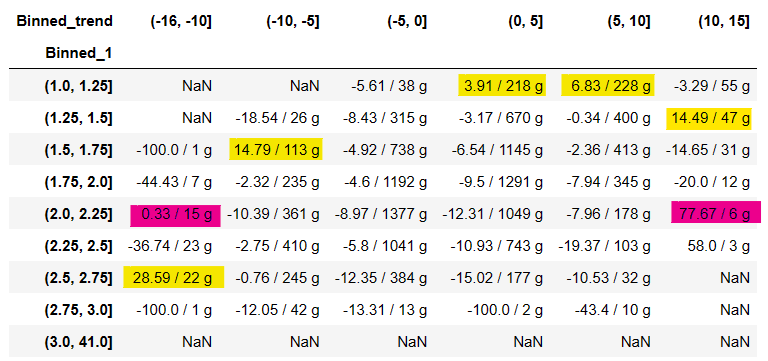

### Segmented Performance : 'X' Predictions

In [26]:
earned = lambda row: (row['Odd_X']) if row['Outcome = Prediction?'] == True else 0

test_df_sub_X['Earning'] = test_df_sub_X.apply(earned,axis=1)

print(test_df_sub_X)


print(test_df_sub_X.groupby(['Binned_X'])['Earning'].sum())
print(test_df_sub_X.groupby(['Binned_trend'])['Earning'].sum())

df_segments_X = pd.DataFrame(index = test_df_sub_X.groupby(['Binned_X'])['Earning'].sum().index, columns = test_df_sub_X.groupby(['Binned_trend'])['Earning'].sum().index)


for i in range(len(df_segments_X.index)):
    for j in range(len(df_segments_X.columns)):
        s = test_df_sub_X[(test_df_sub_X['Binned_X'] == df_segments_X.index[i]) \
                          & (test_df_sub_X['Binned_trend'] == df_segments_X.columns[j])]['Earning']
        if s.count() !=0:
            df_segments_X.iloc[i,j] = round(100*(s.sum()/s.count()-1),2)
            df_segments_X.iloc[i,j] = f'{df_segments_X.iloc[i,j]} / {s.count()} g'

            
df_segments_X

     Odd_1  Odd_X  Odd_2  Trend delta (H-A) Outcome Prediction  \
0     2.49   3.10   2.50                  0       X          X   
1     2.45   2.80   2.89                  0       X          X   
2     2.45   3.10   2.80                  0       1          X   
3     2.70   2.74   2.94                  0       1          X   
4     2.15   2.80   3.46                  0       X          X   
..     ...    ...    ...                ...     ...        ...   
405   2.70   2.70   2.61                  0       2          X   
406   2.45   3.20   2.56                  0       1          X   
407   2.65   3.10   2.84                  0       2          X   
408   2.40   3.20   2.62                  0       X          X   
409   2.45   3.10   2.63                  0       X          X   

     Outcome = Prediction?     Binned_1     Binned_X     Binned_2  \
0                     True  (2.25, 2.5]  (3.0, 3.25]  (2.25, 2.5]   
1                     True  (2.25, 2.5]  (2.75, 3.0]  (2.75, 3.0]   


Binned_trend,"(-16, -10]","(-10, -5]","(-5, 0]","(0, 5]","(5, 10]","(10, 15]"
Binned_X,,,,,,
"(1.0, 1.25]",NaN,NaN,NaN,NaN,NaN,NaN
"(1.25, 1.5]",NaN,NaN,-100.0 / 1 g,36.5 / 2 g,NaN,NaN
"(1.5, 1.75]",NaN,NaN,-100.0 / 1 g,NaN,NaN,NaN
"(1.75, 2.0]",NaN,NaN,90.0 / 1 g,90.0 / 1 g,NaN,NaN
"(2.0, 2.25]",NaN,NaN,-25.0 / 3 g,110.0 / 1 g,NaN,NaN
"(2.25, 2.5]",NaN,NaN,-100.0 / 2 g,NaN,NaN,NaN
"(2.5, 2.75]",NaN,-100.0 / 2 g,39.22 / 41 g,-26.36 / 11 g,NaN,NaN
"(2.75, 3.0]",NaN,-100.0 / 1 g,-3.51 / 140 g,9.05 / 21 g,NaN,NaN
"(3.0, 3.25]",NaN,-100.0 / 1 g,9.92 / 169 g,-100.0 / 1 g,NaN,NaN


We highlighted similarly as above the profitable segments. The yellow ones make up this time 59% of the 'X' predictions, thus saving more than half of them while enhancing the profitability.

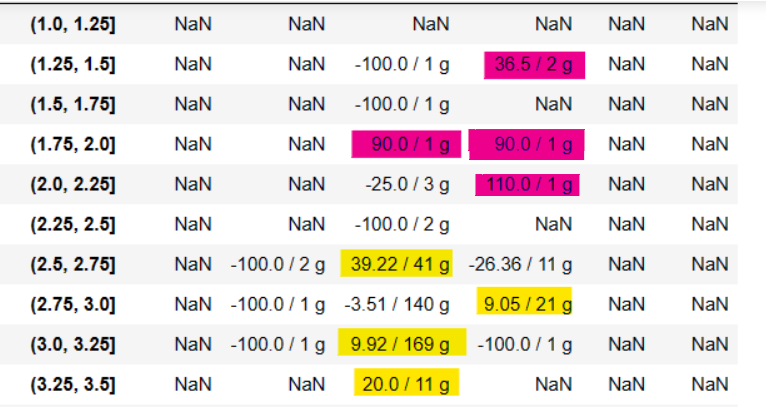

### Segmented Performance : '2' Predictions

In [27]:
earned = lambda row: (row['Odd_2']) if row['Outcome = Prediction?'] == True else 0

test_df_sub_2['Earning'] = test_df_sub_2.apply(earned,axis=1)
print(len(test_df_sub_2))
print(test_df_sub_2[['Prediction', 'Outcome','Odd_2','Outcome = Prediction?', 'Earning']])


print(test_df_sub_2.groupby(['Binned_2'])['Earning'].sum())
print(test_df_sub_2.groupby(['Binned_trend'])['Earning'].sum())
print(test_df_sub_2['Earning'].sum())


df_segments_2 = pd.DataFrame(index = test_df_sub_2.groupby(['Binned_2'])['Earning'].sum().index, columns = test_df_sub_2.groupby(['Binned_trend'])['Earning'].sum().index)




for i in range(len(df_segments_2.index)):
    for j in range(len(df_segments_2.columns)):
        s = test_df_sub_2[(test_df_sub_2['Binned_2'] == df_segments_2.index[i]) \
                          & (test_df_sub_2['Binned_trend'] == df_segments_2.columns[j])]['Earning']
        if s.count() !=0:
            df_segments_2.iloc[i,j] = round(100*(s.sum()/s.count()-1),2)
            df_segments_2.iloc[i,j] = f'{df_segments_2.iloc[i,j]} / {s.count()} g'

            
df_segments_2

4557
     Prediction Outcome  Odd_2  Outcome = Prediction?  Earning
0             2       2   2.61                   True     2.61
1             2       1   2.40                  False     0.00
2             2       2   2.33                   True     2.33
3             2       1   2.47                  False     0.00
4             2       X   1.94                  False     0.00
...         ...     ...    ...                    ...      ...
4552          2       2   1.97                   True     1.97
4553          2       2   2.30                   True     2.30
4554          2       1   2.15                  False     0.00
4555          2       2   1.86                   True     1.86
4556          2       2   1.80                   True     1.80

[4557 rows x 5 columns]
Binned_2
(1.0, 1.25]       74.35
(1.25, 1.5]      334.23
(1.5, 1.75]      567.29
(1.75, 2.0]      728.04
(2.0, 2.25]      928.36
(2.25, 2.5]     1118.47
(2.5, 2.75]      486.58
(2.75, 3.0]      101.55
(3.0, 3.25]  

Binned_trend,"(-16, -10]","(-10, -5]","(-5, 0]","(0, 5]","(5, 10]","(10, 15]"
Binned_2,,,,,,
"(1.0, 1.25]",3.91 / 23 g,-5.32 / 38 g,-19.8 / 15 g,22.0 / 2 g,NaN,NaN
"(1.25, 1.5]",-9.12 / 52 g,-7.61 / 188 g,12.68 / 98 g,-64.25 / 4 g,41.0 / 1 g,NaN
"(1.5, 1.75]",-5.81 / 69 g,-0.95 / 260 g,0.02 / 205 g,-17.25 / 48 g,-100.0 / 1 g,NaN
"(1.75, 2.0]",-30.77 / 57 g,-4.34 / 277 g,-7.61 / 348 g,2.5 / 96 g,-38.83 / 6 g,NaN
"(2.0, 2.25]",-25.9 / 29 g,-8.63 / 322 g,-6.47 / 484 g,-2.25 / 157 g,-35.0 / 10 g,NaN
"(2.25, 2.5]",-31.1 / 31 g,1.9 / 274 g,-5.42 / 588 g,1.82 / 243 g,-10.38 / 16 g,NaN
"(2.5, 2.75]",-34.0 / 8 g,-11.26 / 118 g,-2.36 / 228 g,1.5 / 144 g,56.4 / 5 g,NaN
"(2.75, 3.0]",-100.0 / 2 g,1.21 / 14 g,-3.34 / 44 g,-12.06 / 51 g,NaN,NaN
"(3.0, 3.25]",NaN,NaN,NaN,205.0 / 1 g,NaN,NaN


Here, we retain 7 segments (but one with profit at the edge of 0) that make up 24% of the away victory predictions.

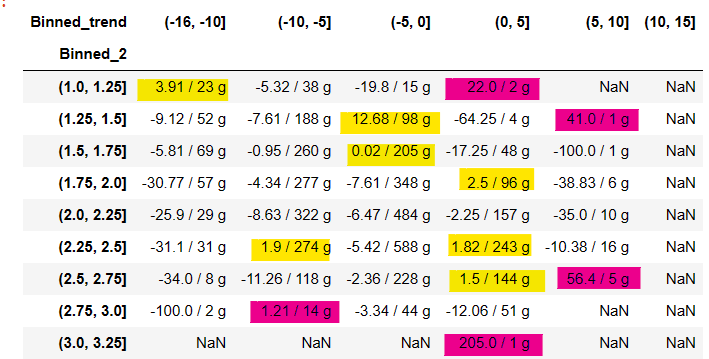

The segments on which we are winning represent 1953 games, that is 10.4% of our test set. Let's compute how much we are winning, in absolute and relative value, if we follow the model only on these segments, and don't bet otherwise.

### Earning Computation

#### '1' Predictions

In [28]:
one_earning = (218*0.0391)+(228*0.0683)+(0.1449*47)+(0.1479*113)+(22*0.2859)

print('Earned in absolute value')
print(f'{one_earning:.2f}')
print('Earned in %')
print(f'{100*(one_earning/628):.2f}%')

Earned in absolute value
53.91
Earned in %
8.58%


#### 'X' Predictions

In [29]:
x_earning = (0.3922*41)+(0.0992*169)+(0.0905*21)+(0.2*11)

print('Earned in absolute value')
print(f'{x_earning:.2f}')
print('Earned in %')
print(f'{100*(x_earning/242):.2f}%')


Earned in absolute value
36.95
Earned in %
15.27%


#### '2' Predictions

In [30]:
two_earning = (0.0391*23)+(0.1268*98)+(0.0002*205)+(0.025*96)+(0.019*274)+(0.0182*243)+(0.015*144)

print('Earned in absolute value')
print(f'{two_earning:.2f}')
print('Earned in %')
print(f'{100*(two_earning/1083):.2f}%')


Earned in absolute value
27.56
Earned in %
2.54%


#### Overall

In [31]:
overall_earning = one_earning+x_earning+two_earning

print('Earned in absolute value, overall')
print(f'{overall_earning:.2f}')
print('Earned in %, overall')
print(f'{100*(overall_earning/1953):.2f}%')

Earned in absolute value, overall
118.41
Earned in %, overall
6.06%


This result is assuming that we bet 1 bankroll unit on each game, resulting in earning ca. 0.06 unit per game in average. It is low but by betting instead 10 units we could earn 0.6 unit per game, 100 units 6 units, and so on. If a model proves to be working, we can be confident to risk more money so as to get results that are satisfactory. 

Based on our findings about the segments we want to include/exclude, let's slightly correct the K Nearest Neighbors Classifier by introducing the 'no bet' option. To note that we will have to create a copy of the bookmaker's original data and to normalize those data to generate the model's initial prediction. After this step, the original data will be used again to check that the conditions for placing a bet are met.

In [32]:
# We start by creating an helper function that will help checking if the conditions for using the prediction are met

def conditions_check(input, left, right):
    return (left < input <= right)

# Plus a second helper function that we will use to normalize the input versus the dataset's mean and standard deviation

def normalize(input):
    normalized_input = []
    normalized_input.append((input[2]- 2.4673030995663603)/1.369699325693504)
    normalized_input.append((input[3]- 3.5779339072479868)/0.9842687690461931)
    normalized_input.append((input[4]- 3.9639052186358494)/2.79639654496435)
    normalized_input.append((input[5]-input[6]+0.2483177749770363)/4.491125633194449)
    normalized_input = np.array(normalized_input).reshape(1,-1)
    return normalized_input


print(normalize([1,1,2.25,2.95,2.95,5,4]))
print(KNN_model.predict(normalize([1,1,2.25,2.95,2.95,5,4])))
print(normalize([1,1,1.6,3.4,4.9,5,9]))
print(KNN_model.predict(normalize([1,1,1.6,3.4,4.9,5,9])))
print(normalize([1,1,1.54,3.5,5.4,3,9]))
print(KNN_model.predict(normalize([1,1,1.54,3.5,5.4,3,9])))


# Second helper function to return pot. win with comma rather than point, to be read by our external spreadsheet as number
def point_to_comma(input):
    str_a = ''
    str_b = ','
    split_list = str(input).split('.')
    str_a += split_list[0]
    str_b += split_list[1]
    final_string = str_a+str_b
    return final_string



      
# Individual model input structured as list containing: home team, away team, Odd_1, Odd_x, Odd_2, Trend_home, Trend_away

def KNN_segmented_predictors(inputs):                          
    output = {}
    for input in inputs:
        game = input[0] + '-' + input[1]
        Odd_1 = input[2]
        Odd_X = input[3]
        Odd_2 = input[4]
        trend_balance = input[5]-input[6]
        pred = KNN_model.predict(normalize(input))
        conditions = {'1': (conditions_check(Odd_1,2.5,2.75) and conditions_check(trend_balance, -15, -10))\
        or (conditions_check(Odd_1,1.5,1.75) and conditions_check(trend_balance, -10, -5))\
        or (conditions_check(Odd_1,1.0,1.25) and conditions_check(trend_balance, 0, 5))\
        or (conditions_check(Odd_1,1.0,1.25) and conditions_check(trend_balance, 5, 10))\
        or (conditions_check(Odd_1,1.25,1.5) and conditions_check(trend_balance, 10, 16)),\
        'X' : (conditions_check(Odd_X,2.5,2.75) and conditions_check(trend_balance, -5, 0))\
        or (conditions_check(Odd_X,2.75,3) and conditions_check(trend_balance, -5, 0))\
        or (conditions_check(Odd_X,3,3.25) and conditions_check(trend_balance, -5, 0))\
        or (conditions_check(Odd_X,3.25,3.5) and conditions_check(trend_balance, -5, 0)),\
        '2' : (conditions_check(Odd_2,1,1.25) and conditions_check(trend_balance, -15, -10))\
        or (conditions_check(Odd_2,2.25,2.5) and conditions_check(trend_balance, -10, -5))\
        or (conditions_check(Odd_2,1.25,1.5) and conditions_check(trend_balance, -5, 0))\
        or (conditions_check(Odd_2,1.5,1.75) and conditions_check(trend_balance, -5, 0))\
        or (conditions_check(Odd_2,2.5,2.75) and conditions_check(trend_balance, -5, 0))\
        or (conditions_check(Odd_2,1.75,2) and conditions_check(trend_balance, 0,5))\
        or (conditions_check(Odd_2,2.25,2.5) and conditions_check(trend_balance, 0,5))\
        or (conditions_check(Odd_2,2.5,2.75) and conditions_check(trend_balance, 0,5))} 
        if not conditions[pred[0]]:
            output[game] = 'no bet'
        else:
            output[game] = pred[0]
    table = pd.DataFrame(index=output.keys(), data = {'bet':output.values(), 'date': datetime.strftime(datetime.now(),'%b %d')})
    pot_win = []
    for i in range(len(table.index)):
        if table.bet[i] == '1':
            pot_win.append(point_to_comma(round(inputs[i][2]-1,2)))
        elif table.bet[i] == 'X':
            pot_win.append(point_to_comma(round(inputs[i][3]-1,2)))
        elif table.bet[i] == '2':
            pot_win.append(point_to_comma(round(inputs[i][4]-1,2)))
        else:
            pot_win.append(0)    
    table['pot. win'] = pot_win
    return table
        



[[-0.15865022 -0.63796996 -0.36257562  0.27795209]]
['1']
[[-0.63320693 -0.18077776  0.33475037 -0.83535455]]
['1']
[[-0.67701216 -0.0791795   0.51355191 -1.28067721]]
['1']


Let us test this model with 9 games in real life, the predictive data of which are taken from our usual bookmaker.
When the end results are known, we will compare them with what the model with the 'no bet' option predicted. 
Results all known by the 1/4/2024 end of day!

In [33]:
games_data = [['Osasuna', 'Almeria', 1.68, 3.7, 5, 6, 2], ['Las Palmas', 'Barcelone', 5.9, 4.2, 1.5,10,7],\
             ['Juve', 'Salernitana', 1.18, 6.5, 15,11,4], ['Panetolikos', 'Panserraikos', 2.1, 2.85, 2.80,4,1],\
             ['Atromitos', 'Kifisias', 1.64, 3.25, 3.9,9,3],\
             ['Union de Touarga', 'Olympic Safi', 2.15, 2.65, 2.85,4,8], ['RSB Berkane', 'Riadi Salmi', 1.4, 3.45, 5.8,9,5],\
             ['Yous Berrechid', 'Agadir', 2.1, 2.65, 3.5,4,3], ['FAR Rabat', 'Moghreb Tetouan', 1.13, 5, 10,12,5]]

print(KNN_segmented_predictors(games_data))


print(len(X_test))

                                  bet    date             pot. win
Osasuna-Almeria                no bet  Feb 08                    0
Las Palmas-Barcelone           no bet  Feb 08                    0
Juve-Salernitana                    1  Feb 08  0,17999999999999994
Panetolikos-Panserraikos       no bet  Feb 08                    0
Atromitos-Kifisias             no bet  Feb 08                    0
Union de Touarga-Olympic Safi  no bet  Feb 08                    0
RSB Berkane-Riadi Salmi        no bet  Feb 08                    0
Yous Berrechid-Agadir          no bet  Feb 08                    0
FAR Rabat-Moghreb Tetouan           1  Feb 08   0,1299999999999999
18726


The model directs to bet on 2 cases only out of 9, which is due to the strict conditions we implemented. 22% is more than the
some 10.4% of the test set that the highlighted winning segments compose. We could also introduce some sort of human intervention by betting against the model's verdict on a victory of Barcelona against Las Palmas.

Update: on the games for which the model actually directed to an action, the model proved to be correct!

## 2nd approach: segmentization per predicted probabilities

This second approach is going to calculate how "certain" the model is of the outcome it predicts, based on the probabilities it gives to each of the outcomes. We will introduce an index that is measuring the strength of the advantage of the predicted outcome's probability over the two other probabilities. If the outcome being predicted is a victory of either side, we will introduce in the calculation a weight enhancing the importance of the "most distant" outcome (i.e. victory of the opposite side). The aim here is to scale the predicted outcome's probability by the probability of the opposite outcome's probability. 

If we have for example respective probabilities of 50%-35%-15% on the one hand, and 50%-15%-35% on the other hand, we should mitigate the model's tendancy to predict the 50% outcome in the second case versus the first one, because the most distant outcome is more likely in this case and we can therefore assume that in reality, the 50% outcome is more likely in first case than in second case. The challenge will be to find the proper weight.

In [34]:
print(KNN_preds_proba)
print(KNN_preds_proba.transpose())

test_df['home_proba'] = KNN_preds_proba.transpose()[0]
test_df['draw_proba'] = KNN_preds_proba.transpose()[2]
test_df['away_proba'] = KNN_preds_proba.transpose()[1]

max = lambda row: np.max(row[['home_proba', 'draw_proba', 'away_proba']])
strength = lambda row: np.max(row[['home_proba', 'draw_proba', 'away_proba']])/(1-np.max(row[['home_proba', 'draw_proba', 'away_proba']]))


test_df['max_proba'] = test_df.apply(max,axis=1)
test_df['prediction_strength'] = test_df.apply(strength, axis =1)
test_df

[[0.35021097 0.36568214 0.28410689]
 [0.38255977 0.30379747 0.31364276]
 [0.47538678 0.24894515 0.27566807]
 ...
 [0.19831224 0.53305204 0.26863572]
 [0.70323488 0.11673699 0.18002813]
 [0.20253165 0.55555556 0.2419128 ]]
[[0.35021097 0.38255977 0.47538678 ... 0.19831224 0.70323488 0.20253165]
 [0.36568214 0.30379747 0.24894515 ... 0.53305204 0.11673699 0.55555556]
 [0.28410689 0.31364276 0.27566807 ... 0.26863572 0.18002813 0.2419128 ]]


,Odd_1,Odd_X,Odd_2,Trend delta (H-A),Outcome,Prediction,Outcome = Prediction?,Binned_1,Binned_X,Binned_2,Binned_trend,home_proba,draw_proba,away_proba,max_proba,prediction_strength
0,2.70,3.60,2.61,-5,2,2,True,"(2.5, 2.75]","(3.5, 3.75]","(2.5, 2.75]","(-10, -5]",0.350211,0.284107,0.365682,0.365682,0.576497
1,2.55,3.25,2.54,1,2,1,False,"(2.5, 2.75]","(3.0, 3.25]","(2.5, 2.75]","(0, 5]",0.382560,0.313643,0.303797,0.382560,0.619590
2,1.91,3.40,3.40,-7,1,1,True,"(1.75, 2.0]","(3.25, 3.5]","(3.25, 3.5]","(-10, -5]",0.475387,0.275668,0.248945,0.475387,0.906166
3,1.45,3.80,6.32,2,1,1,True,"(1.25, 1.5]","(3.75, 4.0]","(6.0, 6.5]","(0, 5]",0.607595,0.265823,0.126582,0.607595,1.548387
4,2.70,3.10,2.40,-2,1,2,False,"(2.5, 2.75]","(3.0, 3.25]","(2.25, 2.5]","(-5, 0]",0.341772,0.285513,0.372714,0.372714,0.594170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18721,2.70,3.25,2.75,1,1,1,True,"(2.5, 2.75]","(3.0, 3.25]","(2.5, 2.75]","(0, 5]",0.338959,0.322082,0.338959,0.338959,0.512766
18722,1.48,3.80,5.41,2,X,1,False,"(1.25, 1.5]","(3.75, 4.0]","(5.0, 5.5]","(0, 5]",0.606188,0.246132,0.147679,0.606188,1.539286
18723,4.20,3.60,1.86,-2,2,2,True,"(3.0, 41.0]","(3.5, 3.75]","(1.75, 2.0]","(-5, 0]",0.198312,0.268636,0.533052,0.533052,1.141566
18724,1.51,4.55,6.50,4,X,1,False,"(1.5, 1.75]","(4.5, 4.75]","(6.0, 6.5]","(0, 5]",0.703235,0.180028,0.116737,0.703235,2.369668


We have added to the 'test_df' dataframe the respective calculated probabilities, as well as the maximal one and its relative strength compared to the two others (i.e. the biggest probability divided by the sum of the two others). We now want to investigate if there is a correlation between prediction strength and prediction accuracy and increased benefit (remember that higher accuracy doesn't necessarily mean higher benefit because the returns get lower as we predict the most expected results).

We will examine this relationship for each type of prediction and, in the case of the non-draw outcomes, we also would like to finetune the 'prediction_strength' indicator so as to give a higher weight to the 'farthest' outcome.

### Segmented prediction strengths: '1' Predictions

We start by creating a column resulting from the binning of the 'prediction_strength' values. The bins are of unequal spreads to ensure an equilibrated allocation of the datapoints to each of them.

0.5031712473572938
7.8875
count    13759.000000
mean         1.233243
std          0.968264
min          0.503171
25%          0.713253
50%          0.890957
75%          1.323529
max          7.887500
Name: prediction_strength, dtype: float64


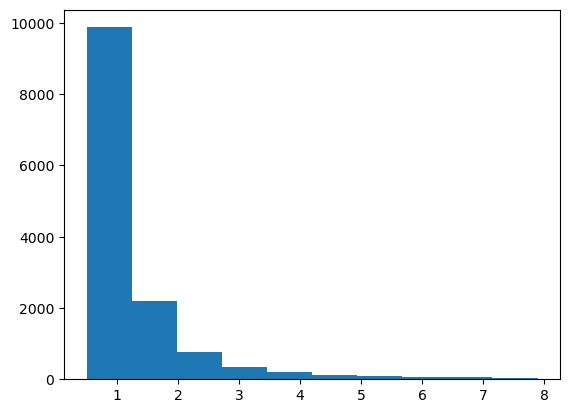

C:\Users\em17\AppData\Local\Temp\ipykernel_20348\2085083262.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_1['prediction_strength_binned'] = pd.cut(test_df_sub_1['prediction_strength'], strength_bins)


,Odd_1,Odd_X,Odd_2,Trend delta (H-A),Outcome,Prediction,Outcome = Prediction?,Binned_1,Binned_X,Binned_2,Binned_trend,home_proba,draw_proba,away_proba,max_proba,prediction_strength,prediction_strength_binned
1,2.55,3.25,2.54,1,2,1,False,"(2.5, 2.75]","(3.0, 3.25]","(2.5, 2.75]","(0, 5]",0.382560,0.313643,0.303797,0.382560,0.619590,"(0.616, 0.646]"
2,1.91,3.40,3.40,-7,1,1,True,"(1.75, 2.0]","(3.25, 3.5]","(3.25, 3.5]","(-10, -5]",0.475387,0.275668,0.248945,0.475387,0.906166,"(0.891, 0.937]"
3,1.45,3.80,6.32,2,1,1,True,"(1.25, 1.5]","(3.75, 4.0]","(6.0, 6.5]","(0, 5]",0.607595,0.265823,0.126582,0.607595,1.548387,"(1.469, 1.693]"
5,1.48,4.40,5.40,6,2,1,False,"(1.25, 1.5]","(4.25, 4.5]","(5.0, 5.5]","(5, 10]",0.676512,0.201125,0.122363,0.676512,2.091304,"(1.693, 2.292]"
6,1.47,3.75,5.80,1,1,1,True,"(1.25, 1.5]","(3.5, 3.75]","(5.5, 6.0]","(0, 5]",0.611814,0.265823,0.122363,0.611814,1.576087,"(1.469, 1.693]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18719,2.10,3.30,3.40,0,X,1,False,"(2.0, 2.25]","(3.25, 3.5]","(3.25, 3.5]","(-5, 0]",0.427567,0.329114,0.243319,0.427567,0.746929,"(0.713, 0.747]"
18720,2.00,3.30,4.10,3,2,1,False,"(1.75, 2.0]","(3.25, 3.5]","(4.0, 4.25]","(0, 5]",0.448664,0.312236,0.239100,0.448664,0.813776,"(0.809, 0.847]"
18721,2.70,3.25,2.75,1,1,1,True,"(2.5, 2.75]","(3.0, 3.25]","(2.5, 2.75]","(0, 5]",0.338959,0.322082,0.338959,0.338959,0.512766,"(0.5, 0.58]"
18722,1.48,3.80,5.41,2,X,1,False,"(1.25, 1.5]","(3.75, 4.0]","(5.0, 5.5]","(0, 5]",0.606188,0.246132,0.147679,0.606188,1.539286,"(1.469, 1.693]"


In [35]:
test_df_sub_1 = test_df[test_df['Prediction'] == '1']

print(np.min(test_df_sub_1['prediction_strength']))
print(np.max(test_df_sub_1['prediction_strength']))
print(test_df_sub_1['prediction_strength'].describe())
plt.hist(test_df_sub_1['prediction_strength'])
plt.show()

strength_bins = [0.5,\
                np.percentile(test_df_sub_1['prediction_strength'],5),\
                np.percentile(test_df_sub_1['prediction_strength'],10),\
                np.percentile(test_df_sub_1['prediction_strength'],15),\
                np.percentile(test_df_sub_1['prediction_strength'],20),\
                np.percentile(test_df_sub_1['prediction_strength'],25),\
                np.percentile(test_df_sub_1['prediction_strength'],30),\
                np.percentile(test_df_sub_1['prediction_strength'],35),\
                np.percentile(test_df_sub_1['prediction_strength'],40),\
                np.percentile(test_df_sub_1['prediction_strength'],45),\
                np.percentile(test_df_sub_1['prediction_strength'],50),\
                np.percentile(test_df_sub_1['prediction_strength'],55),\
                np.percentile(test_df_sub_1['prediction_strength'],60),\
                np.percentile(test_df_sub_1['prediction_strength'],65),\
                np.percentile(test_df_sub_1['prediction_strength'],70),\
                np.percentile(test_df_sub_1['prediction_strength'],75),\
                np.percentile(test_df_sub_1['prediction_strength'],80),\
                np.percentile(test_df_sub_1['prediction_strength'],85),\
                np.percentile(test_df_sub_1['prediction_strength'],90),\
                np.percentile(test_df_sub_1['prediction_strength'],95),\
                np.max(test_df_sub_1['prediction_strength'])]



test_df_sub_1['prediction_strength_binned'] = pd.cut(test_df_sub_1['prediction_strength'], strength_bins)

test_df_sub_1

For each of the created bins, let's summarize the % of gain (or loss) that we get by following the model's predictions.

In [36]:
bins = test_df_sub_1['prediction_strength_binned'].unique()

sorted_bins = bins.sort_values()

bets = []
winning_bets = []
gains = []
returns = []

for i in range(20):
    bet = len(test_df_sub_1[test_df_sub_1['prediction_strength_binned'] == sorted_bins[i]])
    bets.append(bet)
    winning = len(test_df_sub_1[(test_df_sub_1['prediction_strength_binned'] == sorted_bins[i]) & (test_df_sub_1['Outcome = Prediction?'] == True)])
    winning_bets.append(winning)
    gain = np.sum(test_df_sub_1[(test_df_sub_1['prediction_strength_binned'] == sorted_bins[i]) & (test_df_sub_1['Outcome = Prediction?'] == True)]['Odd_1'])
    gains.append(gain)
    returns.append(round(100*((gain/bet)-1),2))

    
pred_strengths_returns_1 = pd.DataFrame({'bets': bets,'winning_bets': winning_bets, 'gains': gains, 'return/loss %': returns})
pred_strengths_returns_1.index = sorted_bins
pred_strengths_returns_1['winning_bets_%'] = 100*round(pred_strengths_returns_1['winning_bets']/pred_strengths_returns_1['bets'],2)
pred_strengths_returns_1 = pred_strengths_returns_1[['bets', 'winning_bets', 'winning_bets_%', 'gains', 'return/loss %']] 

pred_strengths_returns_1

,bets,winning_bets,winning_bets_%,gains,return/loss %
"(0.5, 0.58]",745,253,34.0,651.96,-12.49
"(0.58, 0.616]",682,247,36.0,610.80,-10.44
"(0.616, 0.646]",684,240,35.0,578.34,-15.45
"(0.646, 0.677]",709,270,38.0,628.36,-11.37
"(0.677, 0.713]",649,256,39.0,582.80,-10.20
"(0.713, 0.747]",705,315,45.0,697.71,-1.03
"(0.747, 0.778]",660,286,43.0,615.13,-6.80
"(0.778, 0.809]",700,323,46.0,675.29,-3.53
"(0.809, 0.847]",710,294,41.0,602.84,-15.09
"(0.847, 0.891]",665,305,46.0,611.69,-8.02


We observe that the percentage of winning bets tends to increase almost continuously, with a few fluctuations, with the strength of the prediction of home victory by the model. The return/loss in percents tends to overall increase in the same time, but with more fluctuations, which is due to the decrease of the profit margin as the home victory is more expected. Only one segment, the one representing the ca. 5% of the strongest predictions, displays a profit of 2.09%. Which is still a progress compared to the approach of undiscriminate usage of the model, which results in important loss.

Now, what if we correct the prediction strength to take more into account the probability of the opposite outcome than the draw?
We took the example of two games with respective probabilities of 50%-35%-15% on the one hand, and 50%-15%-35% on the other hand. Normally the prediction strength in both cases should be 50/50 = 1. But what if we consider that in the case where victory of the away team is 35% likely, victory of the home team should be less probable than when away victory is only 15% likely? 

Let's say we assign a 1.1 weight to the away victory probability, then instead of being 1 the prediction strength is of 0.93 in the case with 35% likely away victory, and of 0.97 in the case with 15% likely away victory. Thus such system allows to calculate different prediction strengths for the same home victory probability. By implementing such system, can we increase the profitability? 

We will recalculate the prediction strength with a range of different parameters and perform the same analysis as above. We use a range going from 1.1 to 2.5 with spacing of size 0.1, but we could go even higher if we see an unstopped progression.

In [37]:
Ws = [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]
w=0
strength_weighted_1 = lambda row: row['home_proba']/((w*row['away_proba'])+row['draw_proba'])


for weight in Ws:
    w = weight
    test_df_sub_1[f'pred_strength_w={w}'] = test_df_sub_1.apply(strength_weighted_1,axis = 1)
    strength_bins = [np.min(test_df_sub_1[f'pred_strength_w={w}'])-0.000001,\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],5),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],10),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],15),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],20),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],25),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],30),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],35),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],40),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],45),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],50),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],55),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],60),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],65),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],70),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],75),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],80),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],85),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],90),\
                np.percentile(test_df_sub_1[f'pred_strength_w={w}'],95),\
                np.max(test_df_sub_1[f'pred_strength_w={w}'])]
    test_df_sub_1[f'strength_binned_w={w}'] = pd.cut(test_df_sub_1[f'pred_strength_w={w}'], strength_bins)


test_df_sub_1

C:\Users\em17\AppData\Local\Temp\ipykernel_20348\322501866.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_1[f'pred_strength_w={w}'] = test_df_sub_1.apply(strength_weighted_1,axis = 1)
C:\Users\em17\AppData\Local\Temp\ipykernel_20348\322501866.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_1[f'strength_binned_w={w}'] = pd.cut(test_df_sub_1[f'pred_strength_w={w}'], strength_bins)
C:\Users\em17\AppData\Local\Temp\ipykernel_20348\322501866.py:8: SettingWithCopyWarning: 
A valu

C:\Users\em17\AppData\Local\Temp\ipykernel_20348\322501866.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_1[f'pred_strength_w={w}'] = test_df_sub_1.apply(strength_weighted_1,axis = 1)
C:\Users\em17\AppData\Local\Temp\ipykernel_20348\322501866.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_1[f'strength_binned_w={w}'] = pd.cut(test_df_sub_1[f'pred_strength_w={w}'], strength_bins)
C:\Users\em17\AppData\Local\Temp\ipykernel_20348\322501866.py:8: SettingWithCopyWarning: 
A valu

,Odd_1,Odd_X,Odd_2,Trend delta (H-A),Outcome,Prediction,Outcome = Prediction?,Binned_1,Binned_X,Binned_2,...,pred_strength_w=2.1,strength_binned_w=2.1,pred_strength_w=2.2,strength_binned_w=2.2,pred_strength_w=2.3,strength_binned_w=2.3,pred_strength_w=2.4,strength_binned_w=2.4,pred_strength_w=2.5,strength_binned_w=2.5
1,2.55,3.25,2.54,1,2,1,False,"(2.5, 2.75]","(3.0, 3.25]","(2.5, 2.75]",...,0.402010,"(0.396, 0.419]",0.389573,"(0.384, 0.406]",0.377883,"(0.372, 0.394]",0.366873,"(0.361, 0.383]",0.356488,"(0.351, 0.372]"
2,1.91,3.40,3.40,-7,1,1,True,"(1.75, 2.0]","(3.25, 3.5]","(3.25, 3.5]",...,0.595385,"(0.565, 0.598]",0.577383,"(0.548, 0.581]",0.560438,"(0.533, 0.564]",0.544459,"(0.518, 0.549]",0.529366,"(0.504, 0.534]"
3,1.45,3.80,6.32,2,1,1,True,"(1.25, 1.5]","(3.75, 4.0]","(6.0, 6.5]",...,1.142857,"(1.026, 1.211]",1.116279,"(0.999, 1.18]",1.090909,"(0.973, 1.15]",1.066667,"(0.948, 1.124]",1.043478,"(0.925, 1.097]"
5,1.48,4.40,5.40,6,2,1,False,"(1.25, 1.5]","(4.25, 4.5]","(5.0, 5.5]",...,1.476819,"(1.211, 1.614]",1.438397,"(1.18, 1.571]",1.401924,"(1.15, 1.53]",1.367254,"(1.124, 1.492]",1.334258,"(1.097, 1.455]"
6,1.47,3.75,5.80,1,1,1,True,"(1.25, 1.5]","(3.5, 3.75]","(5.5, 6.0]",...,1.170299,"(1.026, 1.211]",1.143533,"(0.999, 1.18]",1.117965,"(0.973, 1.15]",1.093514,"(0.948, 1.124]",1.070111,"(0.925, 1.097]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18719,2.10,3.30,3.40,0,X,1,False,"(2.0, 2.25]","(3.25, 3.5]","(3.25, 3.5]",...,0.508957,"(0.492, 0.515]",0.494631,"(0.477, 0.5]",0.481089,"(0.463, 0.485]",0.468269,"(0.449, 0.472]",0.456114,"(0.437, 0.459]"
18720,2.00,3.30,4.10,3,2,1,False,"(1.75, 2.0]","(3.25, 3.5]","(4.0, 4.25]",...,0.550950,"(0.537, 0.565]",0.535235,"(0.521, 0.548]",0.520392,"(0.506, 0.533]",0.506349,"(0.492, 0.518]",0.493045,"(0.479, 0.504]"
18721,2.70,3.25,2.75,1,1,1,True,"(2.5, 2.75]","(3.0, 3.25]","(2.5, 2.75]",...,0.327847,"(0.324, 0.369]",0.317439,"(0.314, 0.357]",0.307673,"(0.304, 0.346]",0.298489,"(0.295, 0.336]",0.289838,"(0.287, 0.326]"
18722,1.48,3.80,5.41,2,X,1,False,"(1.25, 1.5]","(3.75, 4.0]","(5.0, 5.5]",...,1.089760,"(1.026, 1.211]",1.061576,"(0.999, 1.18]",1.034814,"(0.973, 1.15]",1.009368,"(0.948, 1.124]",0.985143,"(0.925, 1.097]"


In [38]:
bins_wgt = []
for weight in Ws:
    print(weight)
    bins_wgt.append(test_df_sub_1[f'strength_binned_w={weight}'].unique().sort_values())
    
returns = []
games = []

for i in range(15):
    ret = []
    gs = []
    for bin in bins_wgt[i]:
        bets = len(test_df_sub_1[test_df_sub_1[f'strength_binned_w={Ws[i]}'] == bin])
        gs.append(bets)
        gains = test_df_sub_1[(test_df_sub_1[f'strength_binned_w={Ws[i]}'] == bin) & (test_df_sub_1['Outcome = Prediction?'] == True)]['Odd_1'].sum()
        ret.append(round(100*(gains/bets-1),2))    
    games.append(gs)
    returns.append(ret)


dic = {}
for i in range(15):
    dic[f'W={Ws[i]} bins'] = bins_wgt[i]
    dic[f'W={Ws[i]} bin games'] = games[i]
    dic[f'W={Ws[i]} returns %'] = returns[i]

    

returns_wgtd_strength_1 = pd.DataFrame(dic)
returns_wgtd_strength_1[['W=1.1 bins', 'W=1.1 bin games', 'W=1.1 returns %','W=1.2 bins', 'W=1.2 bin games', 'W=1.2 returns %','W=1.3 bins', 'W=1.3 bin games', 'W=1.3 returns %']]

1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2
2.1
2.2
2.3
2.4
2.5


,W=1.1 bins,W=1.1 bin games,W=1.1 returns %,W=1.2 bins,W=1.2 bin games,W=1.2 returns %,W=1.3 bins,W=1.3 bin games,W=1.3 returns %
0,"(0.479, 0.55]",689,-11.10,"(0.457, 0.525]",688,-9.64,"(0.437, 0.501]",688,-8.85
1,"(0.55, 0.586]",687,-12.18,"(0.525, 0.559]",688,-15.25,"(0.501, 0.535]",688,-15.99
2,"(0.586, 0.616]",689,-12.59,"(0.559, 0.589]",690,-9.23,"(0.535, 0.563]",689,-8.73
3,"(0.616, 0.645]",687,-13.39,"(0.589, 0.616]",687,-14.80,"(0.563, 0.59]",687,-15.16
4,"(0.645, 0.681]",689,-9.70,"(0.616, 0.651]",687,-10.43,"(0.59, 0.624]",689,-9.32
5,"(0.681, 0.713]",687,-1.82,"(0.651, 0.683]",689,-0.48,"(0.624, 0.654]",687,-2.77
6,"(0.713, 0.744]",690,-6.32,"(0.683, 0.712]",687,-8.34,"(0.654, 0.683]",689,-7.11
7,"(0.744, 0.774]",688,-5.53,"(0.712, 0.741]",688,-4.97,"(0.683, 0.711]",687,-5.84
8,"(0.774, 0.809]",686,-14.43,"(0.741, 0.776]",689,-12.99,"(0.711, 0.745]",689,-9.98
9,"(0.809, 0.853]",688,-9.22,"(0.776, 0.818]",687,-10.64,"(0.745, 0.786]",687,-12.10


In [39]:
returns_wgtd_strength_1[['W=1.4 bins', 'W=1.4 bin games', 'W=1.4 returns %','W=1.5 bins', 'W=1.5 bin games', 'W=1.5 returns %','W=1.6 bins', 'W=1.6 bin games', 'W=1.6 returns %']]

,W=1.4 bins,W=1.4 bin games,W=1.4 returns %,W=1.5 bins,W=1.5 bin games,W=1.5 returns %,W=1.6 bins,W=1.6 bin games,W=1.6 returns %
0,"(0.419, 0.48]",691,-8.86,"(0.402, 0.461]",688,-9.09,"(0.386, 0.443]",688,-8.70
1,"(0.48, 0.512]",687,-16.23,"(0.461, 0.491]",688,-14.70,"(0.443, 0.473]",689,-15.52
2,"(0.512, 0.54]",686,-8.38,"(0.491, 0.519]",688,-10.30,"(0.473, 0.498]",687,-8.49
3,"(0.54, 0.566]",690,-14.08,"(0.519, 0.544]",693,-12.73,"(0.498, 0.523]",688,-12.74
4,"(0.566, 0.599]",686,-10.54,"(0.544, 0.575]",683,-10.87,"(0.523, 0.553]",688,-11.21
5,"(0.599, 0.628]",688,-3.65,"(0.575, 0.604]",688,-5.02,"(0.553, 0.582]",688,-6.98
6,"(0.628, 0.657]",688,-5.39,"(0.604, 0.632]",691,-4.27,"(0.582, 0.609]",688,-2.24
7,"(0.657, 0.684]",688,-7.07,"(0.632, 0.658]",685,-5.85,"(0.609, 0.635]",693,-7.83
8,"(0.684, 0.716]",688,-9.44,"(0.658, 0.69]",693,-10.81,"(0.635, 0.665]",683,-9.94
9,"(0.716, 0.757]",688,-11.59,"(0.69, 0.729]",684,-10.75,"(0.665, 0.703]",688,-9.38


In [40]:
returns_wgtd_strength_1[['W=1.7 bins', 'W=1.7 bin games', 'W=1.7 returns %','W=1.8 bins', 'W=1.8 bin games', 'W=1.8 returns %','W=1.9 bins', 'W=1.9 bin games', 'W=1.9 returns %']]

,W=1.7 bins,W=1.7 bin games,W=1.7 returns %,W=1.8 bins,W=1.8 bin games,W=1.8 returns %,W=1.9 bins,W=1.9 bin games,W=1.9 returns %
0,"(0.372, 0.426]",688,-8.69,"(0.359, 0.41]",692,-8.86,"(0.346, 0.396]",689,-9.54
1,"(0.426, 0.455]",690,-16.64,"(0.41, 0.439]",685,-14.95,"(0.396, 0.424]",687,-13.43
2,"(0.455, 0.481]",686,-6.18,"(0.439, 0.464]",689,-7.66,"(0.424, 0.448]",689,-9.41
3,"(0.481, 0.504]",688,-12.83,"(0.464, 0.487]",686,-12.93,"(0.448, 0.47]",688,-10.75
4,"(0.504, 0.533]",688,-11.24,"(0.487, 0.515]",688,-10.58,"(0.47, 0.498]",687,-11.15
5,"(0.533, 0.562]",688,-6.74,"(0.515, 0.542]",689,-7.89,"(0.498, 0.524]",688,-8.67
6,"(0.562, 0.587]",688,-1.91,"(0.542, 0.568]",688,-1.56,"(0.524, 0.549]",688,-1.00
7,"(0.587, 0.613]",689,-9.37,"(0.568, 0.592]",687,-9.09,"(0.549, 0.573]",688,-9.16
8,"(0.613, 0.642]",687,-9.69,"(0.592, 0.621]",688,-9.53,"(0.573, 0.601]",688,-9.19
9,"(0.642, 0.679]",688,-9.44,"(0.621, 0.656]",689,-10.85,"(0.601, 0.636]",688,-11.47


In [41]:
returns_wgtd_strength_1[['W=2 bins', 'W=2 bin games', 'W=2 returns %','W=2.1 bins', 'W=2.1 bin games', 'W=2.1 returns %','W=2.2 bins', 'W=2.2 bin games', 'W=2.2 returns %']]

,W=2 bins,W=2 bin games,W=2 returns %,W=2.1 bins,W=2.1 bin games,W=2.1 returns %,W=2.2 bins,W=2.2 bin games,W=2.2 returns %
0,"(0.335, 0.382]",688,-9.40,"(0.324, 0.369]",688,-9.77,"(0.314, 0.357]",690,-9.68
1,"(0.382, 0.41]",689,-13.34,"(0.369, 0.396]",689,-11.54,"(0.357, 0.384]",687,-11.97
2,"(0.41, 0.433]",688,-9.18,"(0.396, 0.419]",687,-10.45,"(0.384, 0.406]",687,-9.74
3,"(0.433, 0.455]",688,-9.81,"(0.419, 0.441]",688,-10.84,"(0.406, 0.427]",688,-10.84
4,"(0.455, 0.482]",687,-11.86,"(0.441, 0.466]",688,-10.31,"(0.427, 0.452]",688,-10.37
5,"(0.482, 0.507]",688,-9.70,"(0.466, 0.492]",691,-9.82,"(0.452, 0.477]",688,-9.39
6,"(0.507, 0.532]",688,-2.09,"(0.492, 0.515]",686,-3.15,"(0.477, 0.5]",688,-3.99
7,"(0.532, 0.554]",689,-7.22,"(0.515, 0.537]",688,-6.11,"(0.5, 0.521]",688,-6.78
8,"(0.554, 0.583]",688,-10.27,"(0.537, 0.565]",687,-11.01,"(0.521, 0.548]",689,-10.10
9,"(0.583, 0.616]",687,-9.72,"(0.565, 0.598]",689,-9.64,"(0.548, 0.581]",687,-9.38


In [42]:
returns_wgtd_strength_1[['W=2.3 bins', 'W=2.3 bin games', 'W=2.3 returns %','W=2.4 bins', 'W=2.4 bin games', 'W=2.4 returns %','W=2.5 bins', 'W=2.5 bin games', 'W=2.5 returns %']]

,W=2.3 bins,W=2.3 bin games,W=2.3 returns %,W=2.4 bins,W=2.4 bin games,W=2.4 returns %,W=2.5 bins,W=2.5 bin games,W=2.5 returns %
0,"(0.304, 0.346]",689,-9.92,"(0.295, 0.336]",688,-9.79,"(0.287, 0.326]",690,-9.68
1,"(0.346, 0.372]",689,-11.86,"(0.336, 0.361]",688,-12.81,"(0.326, 0.351]",688,-13.56
2,"(0.372, 0.394]",686,-8.57,"(0.361, 0.383]",689,-7.15,"(0.351, 0.372]",686,-6.39
3,"(0.394, 0.414]",688,-11.66,"(0.383, 0.402]",688,-10.65,"(0.372, 0.391]",694,-11.02
4,"(0.414, 0.439]",688,-10.22,"(0.402, 0.426]",687,-12.24,"(0.391, 0.414]",683,-12.45
5,"(0.439, 0.463]",689,-9.89,"(0.426, 0.449]",689,-10.12,"(0.414, 0.437]",689,-10.12
6,"(0.463, 0.485]",689,-3.70,"(0.449, 0.472]",687,-2.73,"(0.437, 0.459]",689,-1.44
7,"(0.485, 0.506]",688,-7.48,"(0.472, 0.492]",690,-7.20,"(0.459, 0.479]",685,-8.33
8,"(0.506, 0.533]",688,-10.21,"(0.492, 0.518]",686,-11.17,"(0.479, 0.504]",688,-10.57
9,"(0.533, 0.564]",686,-7.76,"(0.518, 0.549]",690,-7.69,"(0.504, 0.534]",689,-8.44


We observe that we still have only one profitable segment but with a higher profitability, which peaks at 2.67% when we have a weight of 2 or 2.1, for 688 games, to compare with the 2.09% profit out of 678 games displayed above. Overall it gives a return of 4.2 units more, (18.37 vs. 14.17), which is almost a 30% improvement compared to when we do not assign a weight to the opposite outcome. So it did make sense to insert this factor in the formula.

### Segmented prediction strengths: 'X' Predictions

Here as the two other outcomes as the prediction are "equidistant" from it, we will just check the performance of the model on the different prediction strength segments, like we did above in a first step. We have much less data so we will use only 10 bins.

0.5095541401273885
0.7215496368038742
count    410.000000
mean       0.600588
std        0.042046
min        0.509554
25%        0.569536
50%        0.604966
75%        0.627002
max        0.721550
Name: prediction_strength, dtype: float64


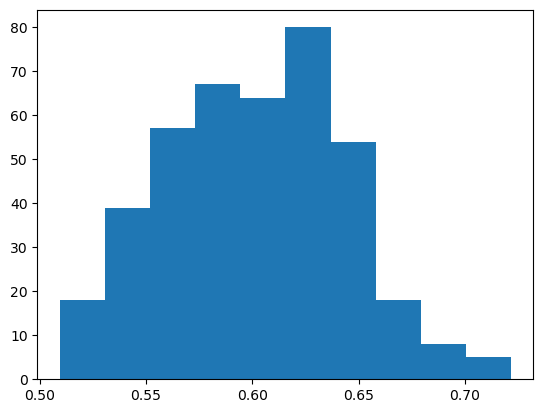

[0.5, 0.5456521739130435, 0.5626373626373626, 0.58, 0.5906040268456376, 0.6049661399548534, 0.6159090909090911, 0.6195899772209565, 0.6382488479262672, 0.6534883720930232, 7.8875]


C:\Users\em17\AppData\Local\Temp\ipykernel_20348\190982910.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_X['prediction_strength_binned'] = pd.cut(test_df_sub_X['prediction_strength'], strength_bins)


,Odd_1,Odd_X,Odd_2,Trend delta (H-A),Outcome,Prediction,Outcome = Prediction?,Binned_1,Binned_X,Binned_2,Binned_trend,home_proba,draw_proba,away_proba,max_proba,prediction_strength,prediction_strength_binned
53,2.49,3.10,2.50,0,X,X,True,"(2.25, 2.5]","(3.0, 3.25]","(2.25, 2.5]","(-5, 0]",0.324895,0.386779,0.288326,0.386779,0.630734,"(0.62, 0.638]"
61,2.45,2.80,2.89,0,X,X,True,"(2.25, 2.5]","(2.75, 3.0]","(2.75, 3.0]","(-5, 0]",0.334740,0.419128,0.246132,0.419128,0.721550,"(0.653, 7.888]"
91,2.45,3.10,2.80,0,1,X,False,"(2.25, 2.5]","(3.0, 3.25]","(2.75, 3.0]","(-5, 0]",0.338959,0.390999,0.270042,0.390999,0.642032,"(0.638, 0.653]"
153,2.70,2.74,2.94,0,1,X,False,"(2.5, 2.75]","(2.5, 2.75]","(2.75, 3.0]","(-5, 0]",0.329114,0.376934,0.293952,0.376934,0.604966,"(0.591, 0.605]"
185,2.15,2.80,3.46,0,X,X,True,"(2.0, 2.25]","(2.75, 3.0]","(3.25, 3.5]","(-5, 0]",0.375527,0.388186,0.236287,0.388186,0.634483,"(0.62, 0.638]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18498,2.70,2.70,2.61,0,2,X,False,"(2.5, 2.75]","(2.5, 2.75]","(2.5, 2.75]","(-5, 0]",0.320675,0.386779,0.292546,0.386779,0.630734,"(0.62, 0.638]"
18537,2.45,3.20,2.56,0,1,X,False,"(2.25, 2.5]","(3.0, 3.25]","(2.5, 2.75]","(-5, 0]",0.329114,0.382560,0.288326,0.382560,0.619590,"(0.616, 0.62]"
18627,2.65,3.10,2.84,0,2,X,False,"(2.5, 2.75]","(3.0, 3.25]","(2.75, 3.0]","(-5, 0]",0.305204,0.381153,0.313643,0.381153,0.615909,"(0.605, 0.616]"
18660,2.40,3.20,2.62,0,X,X,True,"(2.25, 2.5]","(3.0, 3.25]","(2.5, 2.75]","(-5, 0]",0.337553,0.389592,0.272855,0.389592,0.638249,"(0.62, 0.638]"


In [43]:
test_df_sub_X = test_df[test_df['Prediction'] == 'X']

print(np.min(test_df_sub_X['prediction_strength']))
print(np.max(test_df_sub_X['prediction_strength']))
print(test_df_sub_X['prediction_strength'].describe())
plt.hist(test_df_sub_X['prediction_strength'])
plt.show()

strength_bins = [0.5,\
                np.percentile(test_df_sub_X['prediction_strength'],10),\
                np.percentile(test_df_sub_X['prediction_strength'],20),\
                np.percentile(test_df_sub_X['prediction_strength'],30),\
                np.percentile(test_df_sub_X['prediction_strength'],40),\
                np.percentile(test_df_sub_X['prediction_strength'],50),\
                np.percentile(test_df_sub_X['prediction_strength'],60),\
                np.percentile(test_df_sub_X['prediction_strength'],70),\
                np.percentile(test_df_sub_X['prediction_strength'],80),\
                np.percentile(test_df_sub_X['prediction_strength'],90),\
                np.max(test_df_sub_1['prediction_strength'])]

print(strength_bins)

test_df_sub_X['prediction_strength_binned'] = pd.cut(test_df_sub_X['prediction_strength'], strength_bins)

test_df_sub_X

In [44]:
bins = test_df_sub_X['prediction_strength_binned'].unique()
print(bins)

sorted_bins = bins.sort_values()
print(sorted_bins)
bets = []
winning_bets = []
gains = []
returns = []

for i in range(10):
    bet = len(test_df_sub_X[test_df_sub_X['prediction_strength_binned'] == sorted_bins[i]])
    bets.append(bet)
    winning = len(test_df_sub_X[(test_df_sub_X['prediction_strength_binned'] == sorted_bins[i]) & (test_df_sub_X['Outcome = Prediction?'] == True)])
    winning_bets.append(winning)
    gain = np.sum(test_df_sub_X[(test_df_sub_X['prediction_strength_binned'] == sorted_bins[i]) & (test_df_sub_X['Outcome = Prediction?'] == True)]['Odd_X'])
    gains.append(gain)
    returns.append(round(100*((gain/bet)-1),2))

    
pred_strengths_returns_X = pd.DataFrame({'bets': bets,'winning_bets': winning_bets, 'gains': gains, 'return/loss %': returns})
pred_strengths_returns_X.index = sorted_bins
pred_strengths_returns_X['winning_bets_%'] = round(pred_strengths_returns_X['winning_bets']/pred_strengths_returns_X['bets'],2)*100
pred_strengths_returns_X = pred_strengths_returns_X[['bets', 'winning_bets', 'winning_bets_%', 'gains', 'return/loss %']] 

pred_strengths_returns_X

[(0.62, 0.638], (0.653, 7.888], (0.638, 0.653], (0.591, 0.605], (0.605, 0.616], (0.546, 0.563], (0.58, 0.591], (0.5, 0.546], (0.563, 0.58], (0.616, 0.62]]
Categories (10, interval[float64, right]): [(0.5, 0.546] < (0.546, 0.563] < (0.563, 0.58] < (0.58, 0.591] ... (0.616, 0.62] < (0.62, 0.638] < (0.638, 0.653] < (0.653, 7.888]]
[(0.5, 0.546], (0.546, 0.563], (0.563, 0.58], (0.58, 0.591], (0.591, 0.605], (0.605, 0.616], (0.616, 0.62], (0.62, 0.638], (0.638, 0.653], (0.653, 7.888]]
Categories (10, interval[float64, right]): [(0.5, 0.546] < (0.546, 0.563] < (0.563, 0.58] < (0.58, 0.591] ... (0.616, 0.62] < (0.62, 0.638] < (0.638, 0.653] < (0.653, 7.888]]


,bets,winning_bets,winning_bets_%,gains,return/loss %
"(0.5, 0.546]",47,16,34.0,46.92,-0.17
"(0.546, 0.563]",38,18,47.0,54.47,43.34
"(0.563, 0.58]",44,14,32.0,42.02,-4.50
"(0.58, 0.591]",46,17,37.0,50.58,9.96
"(0.591, 0.605]",56,14,25.0,41.51,-25.87
"(0.605, 0.616]",40,10,25.0,28.06,-29.85
"(0.616, 0.62]",19,9,47.0,26.35,38.68
"(0.62, 0.638]",59,24,41.0,68.14,15.49
"(0.638, 0.653]",25,8,32.0,24.52,-1.92
"(0.653, 7.888]",36,18,50.0,50.44,40.11


In [45]:
print(0.4334*38+0.0996*46+0.3868*19+0.1549*59+0.4011*36)
print((0.4334*38+0.0996*46+0.3868*19+0.1549*59+0.4011*36)/198)

51.9787
0.2625186868686869


This approach allows us to secure no less than 5 out of 10 profitable segments with 86 correct out of 198 correct predictions. The profit is of almost 52 units, 26% of the invested sum!

### Segmented prediction strengths: '2' Predictions

Symetrical approach as with the '1' predictions.

0.5031712473572938
3.771812080536912
count    4557.000000
mean        1.024944
std         0.628731
min         0.503171
25%         0.645833
50%         0.827763
75%         1.128743
max         3.771812
Name: prediction_strength, dtype: float64


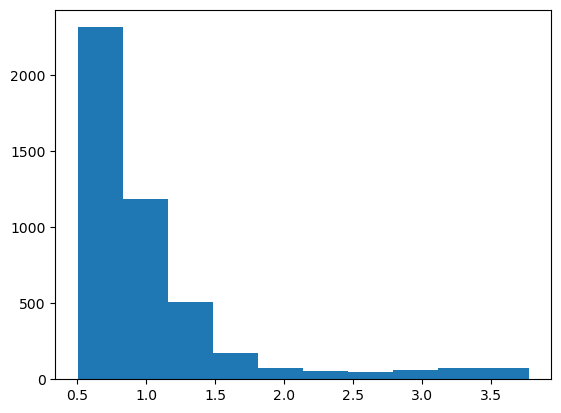

C:\Users\em17\AppData\Local\Temp\ipykernel_20348\40116584.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_2['prediction_strength_binned'] = pd.cut(test_df_sub_2['prediction_strength'], strength_bins)


,Odd_1,Odd_X,Odd_2,Trend delta (H-A),Outcome,Prediction,Outcome = Prediction?,Binned_1,Binned_X,Binned_2,Binned_trend,home_proba,draw_proba,away_proba,max_proba,prediction_strength,prediction_strength_binned
0,2.70,3.60,2.61,-5,2,2,True,"(2.5, 2.75]","(3.5, 3.75]","(2.5, 2.75]","(-10, -5]",0.350211,0.284107,0.365682,0.365682,0.576497,"(0.552, 0.576]"
4,2.70,3.10,2.40,-2,1,2,False,"(2.5, 2.75]","(3.0, 3.25]","(2.25, 2.5]","(-5, 0]",0.341772,0.285513,0.372714,0.372714,0.594170,"(0.576, 0.594]"
14,3.20,3.05,2.33,-6,2,2,True,"(3.0, 41.0]","(3.0, 3.25]","(2.25, 2.5]","(-10, -5]",0.272855,0.288326,0.438819,0.438819,0.781955,"(0.747, 0.786]"
16,3.05,3.00,2.47,-12,1,2,False,"(3.0, 41.0]","(2.75, 3.0]","(2.25, 2.5]","(-16, -10]",0.310830,0.317862,0.371308,0.371308,0.590604,"(0.576, 0.594]"
17,3.30,3.55,1.94,-10,X,2,False,"(3.0, 41.0]","(3.5, 3.75]","(1.75, 2.0]","(-16, -10]",0.267229,0.291139,0.441632,0.441632,0.790932,"(0.786, 0.828]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18708,3.95,3.54,1.97,-7,2,2,True,"(3.0, 41.0]","(3.5, 3.75]","(1.75, 2.0]","(-10, -5]",0.203938,0.253165,0.542897,0.542897,1.187692,"(1.129, 1.215]"
18712,2.83,3.10,2.30,-4,2,2,True,"(2.75, 3.0]","(3.0, 3.25]","(2.25, 2.5]","(-5, 0]",0.333333,0.268636,0.398031,0.398031,0.661215,"(0.646, 0.677]"
18714,3.20,3.80,2.15,-2,1,2,False,"(3.0, 41.0]","(3.75, 4.0]","(2.0, 2.25]","(-5, 0]",0.267229,0.260197,0.472574,0.472574,0.896000,"(0.861, 0.906]"
18723,4.20,3.60,1.86,-2,2,2,True,"(3.0, 41.0]","(3.5, 3.75]","(1.75, 2.0]","(-5, 0]",0.198312,0.268636,0.533052,0.533052,1.141566,"(1.129, 1.215]"


In [46]:
test_df_sub_2 = test_df[test_df['Prediction'] == '2']

print(np.min(test_df_sub_2['prediction_strength']))
print(np.max(test_df_sub_2['prediction_strength']))
print(test_df_sub_2['prediction_strength'].describe())
plt.hist(test_df_sub_2['prediction_strength'])
plt.show()

strength_bins = [0.5,\
                np.percentile(test_df_sub_2['prediction_strength'],5),\
                np.percentile(test_df_sub_2['prediction_strength'],10),\
                np.percentile(test_df_sub_2['prediction_strength'],15),\
                np.percentile(test_df_sub_2['prediction_strength'],20),\
                np.percentile(test_df_sub_2['prediction_strength'],25),\
                np.percentile(test_df_sub_2['prediction_strength'],30),\
                np.percentile(test_df_sub_2['prediction_strength'],35),\
                np.percentile(test_df_sub_2['prediction_strength'],40),\
                np.percentile(test_df_sub_2['prediction_strength'],45),\
                np.percentile(test_df_sub_2['prediction_strength'],50),\
                np.percentile(test_df_sub_2['prediction_strength'],55),\
                np.percentile(test_df_sub_2['prediction_strength'],60),\
                np.percentile(test_df_sub_2['prediction_strength'],65),\
                np.percentile(test_df_sub_2['prediction_strength'],70),\
                np.percentile(test_df_sub_2['prediction_strength'],75),\
                np.percentile(test_df_sub_2['prediction_strength'],80),\
                np.percentile(test_df_sub_2['prediction_strength'],85),\
                np.percentile(test_df_sub_2['prediction_strength'],90),\
                np.percentile(test_df_sub_2['prediction_strength'],95),\
                np.max(test_df_sub_2['prediction_strength'])]



test_df_sub_2['prediction_strength_binned'] = pd.cut(test_df_sub_2['prediction_strength'], strength_bins)

test_df_sub_2

In [47]:
bins = test_df_sub_2['prediction_strength_binned'].unique()

sorted_bins = bins.sort_values()

bets = []
winning_bets = []
gains = []
returns = []

for i in range(20):
    bet = len(test_df_sub_2[test_df_sub_2['prediction_strength_binned'] == sorted_bins[i]])
    bets.append(bet)
    winning = len(test_df_sub_2[(test_df_sub_2['prediction_strength_binned'] == sorted_bins[i]) & (test_df_sub_2['Outcome = Prediction?'] == True)])
    winning_bets.append(winning)
    gain = np.sum(test_df_sub_2[(test_df_sub_2['prediction_strength_binned'] == sorted_bins[i]) & (test_df_sub_2['Outcome = Prediction?'] == True)]['Odd_2'])
    gains.append(gain)
    returns.append(round(100*((gain/bet)-1),2))

    
pred_strengths_returns_2 = pd.DataFrame({'bets': bets,'winning_bets': winning_bets, 'gains': gains, 'return/loss %': returns})
pred_strengths_returns_2.index = sorted_bins
pred_strengths_returns_2['winning_bets_%'] = 100*round(pred_strengths_returns_2['winning_bets']/pred_strengths_returns_2['bets'],2)
pred_strengths_returns_2 = pred_strengths_returns_2[['bets', 'winning_bets', 'winning_bets_%', 'gains', 'return/loss %']] 
pred_strengths_returns_2['return/loss abs'] = pred_strengths_returns_2['bets']*(0.01*pred_strengths_returns_2['return/loss %'])


pred_strengths_returns_2

,bets,winning_bets,winning_bets_%,gains,return/loss %,return/loss abs
"(0.5, 0.552]",246,81,33.0,207.10,-15.81,-38.8926
"(0.552, 0.576]",234,85,36.0,215.56,-7.88,-18.4392
"(0.576, 0.594]",233,93,40.0,233.96,0.41,0.9553
"(0.594, 0.62]",225,93,41.0,227.29,1.02,2.2950
"(0.62, 0.646]",202,69,34.0,169.39,-16.14,-32.6028
"(0.646, 0.677]",238,103,43.0,246.22,3.45,8.2110
"(0.677, 0.709]",218,82,38.0,195.45,-10.34,-22.5412
"(0.709, 0.747]",229,99,43.0,226.49,-1.10,-2.5190
"(0.747, 0.786]",233,102,44.0,229.27,-1.60,-3.7280
"(0.786, 0.828]",257,110,43.0,240.08,-6.58,-16.9106


In [48]:
print('Gain in units using positive returns segments')
print(pred_strengths_returns_2[pred_strengths_returns_2['return/loss %']>0]['return/loss abs'].sum())
print('Gain as %  of nb of bets using positive returns segments')
print(100*(pred_strengths_returns_2[pred_strengths_returns_2['return/loss %']>0]['return/loss abs'].sum()\
           /pred_strengths_returns_2[pred_strengths_returns_2['return/loss %']>0]['bets'].sum()))


Gain in units using positive returns segments
21.4554
Gain as %  of nb of bets using positive returns segments
1.5718241758241758


In [49]:
Ws = [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
w=0
strength_weighted_2 = lambda row: row['home_proba']/((w*row['away_proba'])+row['draw_proba'])


for weight in Ws:
    w = weight
    test_df_sub_2[f'pred_strength_w={w}'] = test_df_sub_2.apply(strength_weighted_2,axis = 1)
    strength_bins = [np.min(test_df_sub_2[f'pred_strength_w={w}'])-0.000002,\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],5),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],10),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],15),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],20),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],25),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],30),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],35),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],40),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],45),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],50),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],55),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],60),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],65),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],70),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],75),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],80),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],85),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],90),\
                np.percentile(test_df_sub_2[f'pred_strength_w={w}'],95),\
                np.max(test_df_sub_2[f'pred_strength_w={w}'])]
    test_df_sub_2[f'strength_binned_w={w}'] = pd.cut(test_df_sub_2[f'pred_strength_w={w}'], strength_bins)


test_df_sub_2

C:\Users\em17\AppData\Local\Temp\ipykernel_20348\3761865986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_2[f'pred_strength_w={w}'] = test_df_sub_2.apply(strength_weighted_2,axis = 1)
C:\Users\em17\AppData\Local\Temp\ipykernel_20348\3761865986.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_sub_2[f'strength_binned_w={w}'] = pd.cut(test_df_sub_2[f'pred_strength_w={w}'], strength_bins)
C:\Users\em17\AppData\Local\Temp\ipykernel_20348\3761865986.py:8: SettingWithCopyWarning: 
A v

,Odd_1,Odd_X,Odd_2,Trend delta (H-A),Outcome,Prediction,Outcome = Prediction?,Binned_1,Binned_X,Binned_2,...,pred_strength_w=1.6,strength_binned_w=1.6,pred_strength_w=1.7,strength_binned_w=1.7,pred_strength_w=1.8,strength_binned_w=1.8,pred_strength_w=1.9,strength_binned_w=1.9,pred_strength_w=2,strength_binned_w=2
0,2.70,3.60,2.61,-5,2,2,True,"(2.5, 2.75]","(3.5, 3.75]","(2.5, 2.75]",...,0.402913,"(0.397, 0.43]",0.386646,"(0.381, 0.412]",0.371642,"(0.366, 0.395]",0.357759,"(0.353, 0.38]",0.344875,"(0.34, 0.366]"
4,2.70,3.10,2.40,-2,1,2,False,"(2.5, 2.75]","(3.0, 3.25]","(2.25, 2.5]",...,0.387560,"(0.384, 0.397]",0.371844,"(0.368, 0.381]",0.357353,"(0.354, 0.366]",0.343949,"(0.341, 0.353]",0.331514,"(0.329, 0.34]"
14,3.20,3.05,2.33,-6,2,2,True,"(3.0, 41.0]","(3.0, 3.25]","(2.25, 2.5]",...,0.275490,"(0.265, 0.281]",0.263802,"(0.254, 0.268]",0.253065,"(0.243, 0.257]",0.243169,"(0.233, 0.247]",0.234017,"(0.225, 0.238]"
16,3.05,3.00,2.47,-12,1,2,False,"(3.0, 41.0]","(2.75, 3.0]","(2.25, 2.5]",...,0.340839,"(0.333, 0.345]",0.327504,"(0.32, 0.331]",0.315174,"(0.307, 0.318]",0.303738,"(0.295, 0.306]",0.293103,"(0.284, 0.295]"
17,3.30,3.55,1.94,-10,X,2,False,"(3.0, 41.0]","(3.5, 3.75]","(1.75, 2.0]",...,0.267832,"(0.265, 0.281]",0.256479,"(0.254, 0.268]",0.246050,"(0.243, 0.257]",0.236436,"(0.233, 0.247]",0.227545,"(0.225, 0.238]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18708,3.95,3.54,1.97,-7,2,2,True,"(3.0, 41.0]","(3.5, 3.75]","(1.75, 2.0]",...,0.181795,"(0.177, 0.193]",0.173403,"(0.169, 0.184]",0.165752,"(0.161, 0.176]",0.158748,"(0.155, 0.169]",0.152311,"(0.148, 0.162]"
18712,2.83,3.10,2.30,-4,2,2,True,"(2.75, 3.0]","(3.0, 3.25]","(2.25, 2.5]",...,0.368127,"(0.357, 0.371]",0.352626,"(0.343, 0.356]",0.338378,"(0.33, 0.342]",0.325237,"(0.317, 0.329]",0.313078,"(0.306, 0.318]"
18714,3.20,3.80,2.15,-2,1,2,False,"(3.0, 41.0]","(3.75, 4.0]","(2.0, 2.25]",...,0.262939,"(0.247, 0.265]",0.251256,"(0.236, 0.254]",0.240567,"(0.226, 0.243]",0.230751,"(0.217, 0.233]",0.221704,"(0.208, 0.225]"
18723,4.20,3.60,1.86,-2,2,2,True,"(3.0, 41.0]","(3.5, 3.75]","(1.75, 2.0]",...,0.176825,"(0.162, 0.177]",0.168802,"(0.154, 0.169]",0.161475,"(0.161, 0.176]",0.154758,"(0.155, 0.169]",0.148577,"(0.148, 0.162]"


In [50]:
bins_wgt = []
for weight in Ws:
    print(weight)
    bins_wgt.append(test_df_sub_2[f'strength_binned_w={weight}'].unique().sort_values())
    
returns = []
games = []


for i in range(10):
    ret = []
    gs = []
    for bin in bins_wgt[i]:
        bets = len(test_df_sub_2[test_df_sub_2[f'strength_binned_w={Ws[i]}'] == bin])
        gs.append(bets)
        gains = test_df_sub_2[(test_df_sub_2[f'strength_binned_w={Ws[i]}'] == bin) & (test_df_sub_2['Outcome = Prediction?'] == True)]['Odd_2'].sum()
        ret.append(round(100*(gains/bets-1),2))    
    games.append(gs)
    returns.append(ret)


dic = {}
for i in range(10):
    dic[f'W={Ws[i]} bins'] = bins_wgt[i]
    dic[f'W={Ws[i]} bin games'] = games[i]
    dic[f'W={Ws[i]} returns %'] = returns[i]


    

returns_wgtd_strength_2 = pd.DataFrame(dic)
returns_wgtd_strength_2

1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2


,W=1.1 bins,W=1.1 bin games,W=1.1 returns %,W=1.2 bins,W=1.2 bin games,W=1.2 returns %,W=1.3 bins,W=1.3 bin games,W=1.3 returns %,W=1.4 bins,...,W=1.7 returns %,W=1.8 bins,W=1.8 bin games,W=1.8 returns %,W=1.9 bins,W=1.9 bin games,W=1.9 returns %,W=2 bins,W=2 bin games,W=2 returns %
0,"(0.0713, 0.124]",228,-5.97,"(0.0662, 0.115]",228,-5.97,"(0.0618, 0.108]",228,-5.97,"(0.058, 0.101]",...,-5.97,"(0.0464, 0.0813]",228,-5.97,"(0.0442, 0.0775]",228,-5.97,"(0.0421, 0.074]",228,-5.97
1,"(0.124, 0.182]",228,4.48,"(0.115, 0.17]",228,4.48,"(0.108, 0.16]",228,4.48,"(0.101, 0.151]",...,5.09,"(0.0813, 0.122]",228,5.09,"(0.0775, 0.117]",228,4.45,"(0.074, 0.112]",228,4.45
2,"(0.182, 0.215]",228,-4.93,"(0.17, 0.202]",228,-4.93,"(0.16, 0.19]",228,-4.93,"(0.151, 0.18]",...,-7.63,"(0.122, 0.147]",228,-6.95,"(0.117, 0.141]",228,-6.32,"(0.112, 0.135]",228,-6.32
3,"(0.215, 0.234]",228,0.94,"(0.202, 0.22]",228,0.94,"(0.19, 0.207]",228,0.85,"(0.18, 0.196]",...,0.69,"(0.147, 0.161]",228,-0.96,"(0.141, 0.155]",228,-0.96,"(0.135, 0.148]",228,-1.68
4,"(0.234, 0.254]",228,-3.18,"(0.22, 0.239]",228,-3.38,"(0.207, 0.225]",228,-5.05,"(0.196, 0.214]",...,-4.48,"(0.161, 0.176]",230,-4.36,"(0.155, 0.169]",228,-4.27,"(0.148, 0.162]",228,-3.54
5,"(0.254, 0.279]",227,-4.58,"(0.239, 0.263]",227,-4.48,"(0.225, 0.249]",227,-1.22,"(0.214, 0.236]",...,0.98,"(0.176, 0.195]",225,1.08,"(0.169, 0.187]",227,0.94,"(0.162, 0.18]",227,1.78
6,"(0.279, 0.302]",228,-7.07,"(0.263, 0.285]",228,-6.96,"(0.249, 0.269]",228,-7.57,"(0.236, 0.255]",...,-9.89,"(0.195, 0.212]",228,-9.10,"(0.187, 0.203]",229,-9.79,"(0.18, 0.195]",229,-10.58
7,"(0.302, 0.322]",228,-4.67,"(0.285, 0.303]",228,-4.25,"(0.269, 0.287]",228,-6.07,"(0.255, 0.273]",...,-3.57,"(0.212, 0.226]",228,-3.57,"(0.203, 0.217]",227,-1.99,"(0.195, 0.208]",227,-2.03
8,"(0.322, 0.343]",229,-3.31,"(0.303, 0.324]",228,-4.18,"(0.287, 0.307]",229,-3.66,"(0.273, 0.292]",...,-2.87,"(0.226, 0.243]",228,-1.09,"(0.217, 0.233]",228,-3.96,"(0.208, 0.225]",228,-3.08
9,"(0.343, 0.363]",227,-16.27,"(0.324, 0.342]",228,-16.87,"(0.307, 0.325]",227,-14.65,"(0.292, 0.309]",...,-18.30,"(0.243, 0.257]",228,-20.00,"(0.233, 0.247]",228,-18.17,"(0.225, 0.238]",228,-18.08


In [51]:
for w in Ws:
    returns_wgtd_strength_2[f'W={w} returns abs'] =\
    (0.01*returns_wgtd_strength_2[f'W={w} returns %'])*\
    returns_wgtd_strength_2[f'W={w} bin games']
    print(f'Weight = {w}')
    print(returns_wgtd_strength_2[returns_wgtd_strength_2[f'W={w} returns %']>0][[f'W={w} bins', f'W={w} bin games', f'W={w} returns %', f'W={w} returns abs']])
    print('ABSOLUTE BENEFIT')
    print(round(returns_wgtd_strength_2[returns_wgtd_strength_2[f'W={w} returns %']>0][f'W={w} returns abs'].sum(),2))
    print('BENEFIT IN %')
    print(round((returns_wgtd_strength_2[returns_wgtd_strength_2[f'W={w} returns %']>0][f'W={w} returns abs'].sum()\
                /returns_wgtd_strength_2[returns_wgtd_strength_2[f'W={w} returns %']>0][f'W={w} bin games'].sum())*100,2))


Weight = 1.1
        W=1.1 bins  W=1.1 bin games  W=1.1 returns %  W=1.1 returns abs
1   (0.124, 0.182]              228             4.48            10.2144
3   (0.215, 0.234]              228             0.94             2.1432
10   (0.363, 0.38]              227             9.07            20.5889
18  (0.484, 0.502]              229             6.12            14.0148
19  (0.502, 0.551]              227             7.76            17.6152
ABSOLUTE BENEFIT
64.58
BENEFIT IN %
5.67
Weight = 1.2
        W=1.2 bins  W=1.2 bin games  W=1.2 returns %  W=1.2 returns abs
1    (0.115, 0.17]              228             4.48            10.2144
3    (0.202, 0.22]              228             0.94             2.1432
10  (0.342, 0.359]              227            10.78            24.4706
18   (0.46, 0.477]              228             5.90            13.4520
19  (0.477, 0.521]              227             6.59            14.9593
ABSOLUTE BENEFIT
65.24
BENEFIT IN %
5.73
Weight = 1.3
        W=1.3 b

While with the 1.2 weight we get an absolute profit of 65.24 units which is 5.73% of the invested amount, with the 1.5 weight we get a higher absolute profit of 66.94 units, which corresponds to a lower share (4.9% of the invested amount), because with the 1.5 weight more games are comprised in the profitable segments (1365 vs. 1138 so respectively 29.9 vs. 25% of the datapoints).

If we invest 1000 units using the weight of 1.2, we get a profit of 57.3 units. 
To get such profit with the weight of 1.5, we need to invest 1169 units, which is 16.9% more.
But with the weight of 1.5, we bet on almost 20% more games (1365/1138=1.199).
As shows the table below, using the weight of 1.5 provides a better profitability because compared to weight of 1.2 it minimizes the 'no bet' model outcomes, admitting that in each bet we do we invest 1 unit.

However if we invest 1.25 unit per bet with the 1.2 weight, we get a higher profit than with the 1.5 weight, still with a lower invested sum. 

But for the sake of simplicity, we want to compare the model parameters on a basis of equal investment per game. We also want to maximize the number of times we bet: otherwise, the time to generate a decent profit might be uncomfortably extended. Therefore, we select the 1.5 weight.

In any case, we can only be satisfied of the introduction of the weights to recalculate the 'prediction strength'. It had a powerful impact on requalifying the strength of the '2' predictions on base of '1' probability, and allows us to more than triple the profit, both in relative and absolute terms!

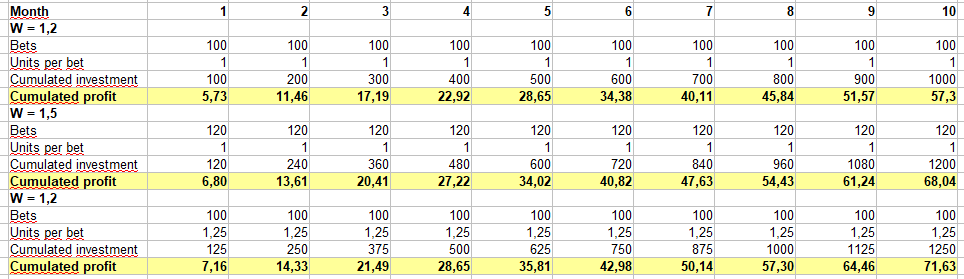

Let us code now an ad-hoc function which will at first use the core nearest neighbors model, then based on its prediction make a check whether the prediction strength conditions are met, and at the end return either a prediction or a 'no bet' recommendation. We just proved that the weight to calculate the prediction strength does improve the performance of the model overall, however our function will preserve the option of using the basic prediction strength (no weight to the opposite outcome) if required. It can be done simply by specifiying 'weight_1' and 'weight_2' equal to 1 when calling the function.

In [52]:
def KNN_pred_strength(inputs, weight_1 = 2, weight_2 = 1.5):    
    #first part is similar as the function for the model segmented according to predictors: format the inputs, make a prediction
    output = {}
    for input in inputs:
        game = input[0] + '-' + input[1]
        Pb_1 = 1/input[2]
        Pb_X = 1/input[3]
        Pb_2 = 1/input[4]
        trend_balance = input[5]-input[6]
        pred = KNN_model.predict(normalize(input))
        # conditions require the calculation of the prediction strength, default respective weights are the ones we found above 
        conditions = {'1': conditions_check(Pb_1/((weight_1*Pb_2)+Pb_X),2.462,6.01),\
        'X' : conditions_check(Pb_1/(Pb_1+Pb_2),0.546,0.563)\
        or conditions_check(Pb_X/(Pb_1+Pb_2),0.58,0.591)\
        or conditions_check(Pb_X/(Pb_1+Pb_2),0.616,0.62)\
        or conditions_check(Pb_X/(Pb_1+Pb_2),0.62,0.638)\
        or conditions_check(Pb_X/(Pb_1+Pb_2),0.653,7.888),\
        '2' : conditions_check(Pb_2/((weight_2*Pb_1)+Pb_X),0.0953,0.143)\
        or conditions_check(Pb_2/((weight_2*Pb_1)+Pb_X),0.17,0.186)\
        or conditions_check(Pb_2/((weight_2*Pb_1)+Pb_X),0.203,0.224)\
        or conditions_check(Pb_2/((weight_2*Pb_1)+Pb_X),0.294,0.31)\
        or conditions_check(Pb_2/((weight_2*Pb_1)+Pb_X),0.4,0.414)\
        or conditions_check(Pb_2/((weight_2*Pb_1)+Pb_X),0.414,0.45)} 
        if not conditions[pred[0]]:
            output[game] = 'no bet'
        else:
            output[game] = pred[0]
    table = pd.DataFrame(index=output.keys(), data = {'bet':output.values(), 'date': datetime.strftime(datetime.now(),'%b %d')})
    pot_win = []
    for i in range(len(table.index)):
        if table.bet[i] == '1':
            pot_win.append(point_to_comma(round(inputs[i][2]-1,2)))
        elif table.bet[i] == 'X':
            pot_win.append(point_to_comma(round(inputs[i][3]-1,2)))
        elif table.bet[i] == '2':
            pot_win.append(point_to_comma(round(inputs[i][4]-1,2)))
        else:
            pot_win.append(0)
    table['pot. win'] = pot_win
    return table

In [53]:
games_data = [['Mali', 'Burkina Faso', 2.05, 2.65, 4.0, 11, 10], ['Maroc', 'Afrique du Sud', 1.5, 3.3, 7.0, 13, 7], ['Nottingham Forest', 'Arsenal', 8.0, 4.7, 1.36, 10, 4], ['Luton Town', 'Brighton', 4.2, 3.9, 1.74, 8, 9], ['Fulham', 'Everton', 2.35, 3.25, 3.0, 7, 5], ['Crystal Palace', 'Sheffield United', 1.58, 3.6, 6.0, 5, 5], ['Aston Villa', 'Newcastle', 1.8, 3.8, 3.8, 8, 3], ['Ouzbékistan', 'Thaïlande', 1.46, 3.2, 5.6, 11, 7], ['Arabie Saoudite', 'Corée du Sud', 4.4, 3.15, 1.6, 10, 13], ['Paris FC (F)', 'Chelsea (F)', 2.8, 3.5, 1.9, 7, 15], ['Real Madrid (F)', 'Häcken (F)', 1.44, 3.6, 5.0, 6, 10], ['Bayern Munich (F)', 'Paris SG (F)', 1.8, 3.2, 3.25, 6, 15], ['Ajax (F)', 'AS Roma (F)', 2.75, 3.5, 1.9, 12, 4], ['FC St. Pauli', 'Fortuna Düsseldorf', 1.74, 3.7, 4.4, 9, 8]]
             

print(KNN_segmented_predictors(games_data))
print(KNN_pred_strength(games_data))

                                    bet    date            pot. win
Mali-Burkina Faso                no bet  Feb 08                   0
Maroc-Afrique du Sud             no bet  Feb 08                   0
Nottingham Forest-Arsenal        no bet  Feb 08                   0
Luton Town-Brighton                   2  Feb 08                0,74
Fulham-Everton                   no bet  Feb 08                   0
Crystal Palace-Sheffield United  no bet  Feb 08                   0
Aston Villa-Newcastle            no bet  Feb 08                   0
Ouzbékistan-Thaïlande            no bet  Feb 08                   0
Arabie Saoudite-Corée du Sud          2  Feb 08  0,6000000000000001
Paris FC (F)-Chelsea (F)         no bet  Feb 08                   0
Real Madrid (F)-Häcken (F)       no bet  Feb 08                   0
Bayern Munich (F)-Paris SG (F)   no bet  Feb 08                   0
Ajax (F)-AS Roma (F)             no bet  Feb 08                   0
FC St. Pauli-Fortuna Düsseldorf  no bet  Feb 08 

# CONCLUSION

This work was performed on a dataset with 96k football games records imported from Kaggle. The upstream data preparation involved simplifying the initial features to focus on the home victory, draw, and away victory events, their odds, derived probabilities and actual outcome out of these 3. 

Later on these outcomes were referred to as '1', 'X' and '2', respectively. 

We also added an indicator totally overlooked in the base dataset, namely the trend of both teams during the last 5 games, expressed as the number of points earned during the last 5 games (victory = 3 pts, draw = 1 pt), or during the last 3 or 4 games with extrapolation, where applicable. This led to remove from the dataset 3k records representing the games with unsufficient number of predecessors for both teams. These records nevertheless were used to calculate the corresponding teams' trend before their future games. Finally, for each remaining record of the dataset we substracted the trend of the away team to the trend of the home team (thus a positive number favours the home team, and a negative one favours the away team). This indicator was labeled as 'trend balance'.

Initial observation of the data showed that the bookmaker's probabilities and the real-life outcomes do importantly differ in the respect of home victories and draws, these two outcomes occuring respectively much less and much more frequently than what the bookmaker's odds/probabilities would suggest (although these are only probabilities with in many cases relative majority only).

Cross-examination of the dataset's games segmented according to outcome did highlight that the predictors we selected do have some relationship, if not absolute, with the end result.

The odds and resulting probabilities given by bookmakers to the three types of outcomes are aligned with the actual occurence rates of these outcomes (which signals a correct evaluation of the situation by the bookmaker, as if it would offer higher odds than what the probability suggests, it would lose money).

Not getting at first into machine learning models, we tried to figure out whether some 'naive' strategies with fixed parameters could bring any profit, over the whole dataset. These attempts weren't fruitul, they are summarized in the below Summary, 'Naive approaches' section.

Subsequently, we trained a K Nearest Neighbors model with a parameter of 711 neighbors and implemented it on a test set of 20% of the whole dataset (18726 records). While the model was bringing some modest benefits in the respect of its draws predictions, it wasn't overall profitable.

So we went on with approaches of segmenting the test set to highlight specific profitable segments to bet on, leaving the other segments aside (it's better not to bet than to be structurally losing). 

The first approach was a segmentation on base of 1) the odds of the KNN model's predicted outcome and 2) the trend balance (with these 2 predictors grouped in bins). 

The second approach was a segmentation on base of how the outcome predicted by the model compares to the two other outcomes as per the bookmaker's probabilities. It was tested with and without a weight used to multiply the probability of the opposite outcome (if '1' or '2' predicted).

Each of these two approaches allowed to highlight profiles of games on which the model does generate some profit. We retained only the segments with profit on a number of games sufficiently high and designed functions able to check if a game meets this profile and where applicable to emit a bet (and to not produce any in opposite case). While using either approach leads to skip betting on approximately 90% of the proposed games, it still appears to generate a decent profit of approximately 6%. The detail can be found in the below Summary, 'Machine Learning approaches' section.  We have started to feed both functions with data of games currently taking place to see how they perform. 

Much of the dataset is from 20, 15 or 10 years in the past, so it is not impossible that through continuous monitoring and improvement our bookmaker has already taken measures to deter the flaws that our study highlighted in the Kaggle dataset and therefore will not let us earn money. 

# SUMMARY OF RESULTS

### Naive approaches

#### Bet on most probable outcome with min. probability threshold

Threshold < 78% : negative but increasing return (from -5.5% to 0%)
Threshold >= 78%: generally small positive return (best with relevant sample 0.96%), but few games available 3981 to 5 (4.3% to 0.005% of the full dataset)

#### S Scenario = bet '1' when trend balance > 3, and '2' when trend balance < -10

Nb. of bets = 18669 (19.94% of full dataset)


|'1'|'1' abs|'1' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|
|17885 (19.10% of ds)|-814.56|-4.55%|784 (0.84% of ds)|-51.31|-6.54%|


#### S Scenario with probability threshold (from 0.5 to 0.9)
  
|0.5|'1'|'1' abs|'1' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|14321 (15% ds)|13749|-517.15|-3.76%|572|-26.34|-4.60%|

|0.6|'1'|'1' abs|'1' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|9123 (10%)|8726|-182.95|-2.10%|397|2.63|0.66%|

|0.7|'1'|'1' abs|'1' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|4812 (5%)|4593|-23.2|-0.51%|219|5.46|2.49%|

|0.8|'1'|'1' abs|'1' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|2082 (2%)|1998|18.53|0.93%|84|0.48|0.57%|

|0.9|'1'|'1' abs|'1' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|296 (0.3%)|287|0.41|0.14%|9|0.81|9%|


### Machine Learning approaches


#### K Nearest Neighbors model with n = 711


|'1'|'1' abs|'1' %|'X'|'X' abs|'X' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|13759 (100%)|-921|-6.69%|410 (100%)|23|5.61%|4557 (100%)|-215|-4.72%|

|'Overall'|'Overall' abs|'Overall' %|
|:-:|:-:|:-:|
|18726 (100%)|-1113|-5.94%|



#### K Nearest Neighbors model with n =  711 PLUS segmented (binned) predictors


|'1'|'1' abs|'1' %|'X'|'X' abs|'X' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|628 (4.56%)|53.91|8.58%|242 (59.02%)|36.95|15.27%|1083 (23.77%)|27.56|2.54%|

|'Overall'|'Overall' abs|'Overall' %|
|:-:|:-:|:-:|
|1953 (10.40%)|118.41|6.06%|


#### K Nearest Neighbors model with n = 711 PLUS revised and segmented (binned) prediction strengths

No weight

|'1'|'1' abs|'1' %|'X'|'X' abs|'X' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|678 (4.9%)|14.17|2.09%|198 (48.29%)|51.98|26.25%|1365 (29.95%)|21.45|1.57%|

|'Overall'|'Overall' abs|'Overall' %|
|:-:|:-:|:-:|
|2241 (11.96%)|87.6|3.91%|

With weight of 2 for '1' predictions and 1.5 for '2' predictions (BEST PERFORMANCE)

|'1'|'1' abs|'1' %|'X'|'X' abs|'X' %|'2'|'2' abs|'2' %|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|688 (5%)|18.37|2.67%|198 (48.29%)|51.98|26.25%|1365 (29.95%)|66.94|4.9%|

|'Overall'|'Overall' abs|'Overall' %|
|:-:|:-:|:-:|
|2251 (12.02%)|137.29|6.1%|